# Product Review Topic Modelling

A report focused on Topic Modeling using [tmtoolkit](https://tmtoolkit.readthedocs.io/) to process text review data from Amazon for clothing and shoes manufactured by Nike. Use unsupervised LDA clustering methods to create popular topics in the Amazon review data.

**Context**
Online marketplaces and applications can product data at volumes too big for a human to read and analyze. An example of this is Amazon, where millions of customers buy and review products. When a company wants to extract insights from their reviews, they need a way to process the text of the reviews and identifty patterns. This exploratory analysis of big data is a common use case for Topic Modeling using unsupervised learning.

**Background**
The Nike brand is interested in extracting key indsights from customer review data on the Amazon website. Specifically, they would like to understand when customers are not satisfied and what major problems they face with their products. To accomplish this task, the Data Science team at Nike is tasked with analyzing the Amazon review data. First, the team must identify Nike's product ASINs on Amazon and extract the relevant reviews. Next, the team will complete topic modeling on the text of the reviews using the LDA clustering method to model the data into popular topics. Finally, the team will vizualize the topics and derive initial insights to drive the strategy of the team.

**LDA (Latent Dirichleyt Allocation)**
This project will focus on the application of [lda.LDA](https://github.com/lda-project/lda), which implements latent Dirichlet allocation (LDA).

Specifically, in natural language processing (NLP), Latent Dirichlet Allocation (LDA) is a Bayesian network used for topic modeling. It aims to explain a set of observations through unobserved groups. Each group explains why some parts of the data are similar. For most purposes, observations are words and are collected into documents. Each word's presence is attributed to one of the document's topics. Each document will contain a small number of topics. [1]

**Data Source**
Prof. Julian McAuley at UC-San Diego created an [Amazon Product Data](http://jmcauley.ucsd.edu/data/amazon/links.html) database, which contains Amazon products details. This project will leverage 2 datasets from the database:
- (1) meta-data about products - details related to each Amazon product
- (2) product reviews - reviews on all types of Amazon products

Since the overall size of these datasets are huge (~80gb), a subset of data will be utilized to focus on the product category of **Clothing, Shoes & Jewelry**.

The raw data sources for the project can be accessed with the following links:
- [Product Data](http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz)
- [Review Data](http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz)

**Overview of Observations**

The **Product Details** dataset has 1,503,384 records in a json format and includes the following fields:
- asin: a unique product id assigned to the Amazon product
- title: the name of the product displayed on the amazon page
- imUrl: a URL to access the product page
- related: related products to the this product
- salesRank: the main sales category and the product rank within the sales category
- categories: categories or tags grouping the products

The **Review Details** dataset has 5,748,920 records in a json format and includes the following fields:
- reviewerID': a unique id assigned to the review
- asin': a unique id of the product reviewed
- reviewerName': the text name of the user who created the review
- helpful': indicator if the review was helpful or not helpful
- reviewText': the text written for the review
- overall': the rating of the product (in stars) on a scale of 1-5
- summary': the summary or title of the review
- unixReviewTime: the numeric unix representation of the time the review was created
- reviewTime: the time the review was created as a formatted data string

**Objective**
The objective is to build a unsupervize topic model for nike product reviews. The topic model will group reviews into topics and create label to identify patterns and trends in user reviews. Final evaluation will use qualitative and look at value of the topics modeled and the usefullness of insights extracted from the topics.

**Report Overview**
The project will cover 5 key phases:
1. Data Source: Extracting, filtering, and focusing the data on the Nike brand
2. Preprocessing: Extracting Word Features with Natural Language Processing (NLP) tools
3. Parameter Tuning: Tuning the topic model parameters to improve the purity and uniqueness of topics
4. Final Model: Building the final topic model
5. Classify and Enright Topic Data: tuning the topic labels, tagging all records, and adding in supporting data to the final dataset
6. Model Evaluation: Review the model and extract insights for the Nike Brand
7. Results: Review the findings of the Topic Evaluation.

## Setting Up
### Importing Libraries

In [1]:
# Special Install of Packages
print('[-] Importing packages...')
#special_install_tmtoolkit
import os
try:
    import tmtoolkit
except:
    print('starting patch of tmtoolkit.')
    !pip install --quiet -U "tmtoolkit[recommended,lda,sklearn,wordclouds,topic_modeling_eval_extra]"
    !pip install -U wordcloud
    print('finished patch of tmtoolkit.')
    os.kill(os.getpid(), 9)

#special_install_lda
import os
try:
    from tmtoolkit.topicmod.tm_lda import compute_models_parallel
except:
    !pip install --quiet tmtoolkit['lda']
    from tmtoolkit.topicmod.tm_lda import compute_models_parallel

try:
    from lda import LDA
except:
    !pip install --quiet lda
    from lda import LDA

#special_install_pyLDAvis
try:
    import pyLDAvis
except:
    !pip install --quiet pyLDAvis==2.1.2
    import pyLDAvis


[-] Importing packages...


In [2]:
print('[-] Importing packages...')
# File Connection and File Manipulation
import os
import pickle
import json
import glob
# Import Usability Functions
import logging
import warnings
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import random
import time
from time import sleep
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Text Preprocessing (tmtoolkit)
import tmtoolkit
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import filter_for_pos, remove_common_tokens, remove_uncommon_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import doc_tokens, tokens_table, doc_labels, dtm
from tmtoolkit.corpus import vocabulary, vocabulary_size, vocabulary_counts
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_doc_frequencies_hist, plot_ranked_vocab_counts
#https://tmtoolkit.readthedocs.io/en/latest/preprocessing.html
# Text Preprocessing(other)
from string import punctuation
import nltk
import scipy.sparse
# Topic Modeling
from lda import LDA
import pyLDAvis
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.bow.bow_stats import doc_lengths
# Sentiment Modeling
from textblob import TextBlob
# normalize
from sklearn.preprocessing import MinMaxScaler

[-] Importing packages...


### Set Global Variables

In [3]:
random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

### Verify GPU Runtime

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Apr  1 01:43:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8             17W /  115W |     833MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Setup Directories

In [5]:
ROOT_DIR = "./"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
    # Create a new directory because it does not exist
    os.makedirs(DATA_DIR)
    print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(EVAL_DIR)
    print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(MODEL_DIR)
    print("The model directory is created!")


### Downloading Data

In [10]:
#link would be expired by the time of the grading. It's just here to show how it could be done.
#import urllib.request
#url = 'https://d3c33hcgiwev3.cloudfront.net/F4BxPB4wTWSAcTweMH1ktA_cf7170556c97498f80af8f7b869f35f1_meta_Clothing_Shoes_and_Jewelry.jsonl.gz?Expires=1711497600&Signature=ABbwkDeNeTL-s2uHXlyu4QweI8JnGGaCopj50~hba0MaEMhk70IImmREl5hzHC6O0mxPkFACpq5PP~JX8XnIEVe1cph7G2neQ0zgW1Q9npt47H-RMjk0p6emo95c8oZ~aWty9kEQBZM3D7PqnwRe7dHRWbZ-eS84gYkvdAq0w48_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'
#filename = './data/meta_Clothing_Shoes_and_Jewelry.jsonl.gz'
#urllib.request.urlretrieve(url, filename)

('./data/meta_Clothing_Shoes_and_Jewelry.jsonl.gz',
 <http.client.HTTPMessage at 0x1e28ab25790>)

In [12]:
#url = 'https://d3c33hcgiwev3.cloudfront.net/ed_p_0DhRh-f6f9A4dYfJA_d374df8f88084b8c9384c9b910b50cf1_reviews_Clothing_Shoes_and_Jewelry.json.gz?Expires=1711497600&Signature=Nllx8wiA27Ey2uOdCpLCRGy-y31pBWRnlXG5AtnpXxVoxPLABKJBTsk4eAcUIGTPzw23f6zckeNTtAbIfOy9w8mCGa4kjFDZAKFAaLXzcmUEs4ia09dzaSYjuduIHhE4ECVvr~VyutJkqfS4MwXxWpgqvwbB44F9RqE5g3P3h6A_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'
#filename = './data/reviews_Clothing_Shoes_and_Jewelry.json.gz'
#urllib.request.urlretrieve(url, filename)

('./data/reviews_Clothing_Shoes_and_Jewelry.json.gz',
 <http.client.HTTPMessage at 0x1e28b6f9ed0>)

In [13]:
#meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz' % DATA_DIR
#review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json.gz' % DATA_DIR

#!gzip -d "$meta_file_path"
#!gzip -d "$review_file_path"

## Examining Product Data

In [34]:
##this assigns the filename we're trying to load in to a string variable
meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl' % DATA_DIR
loadedjson = open(meta_file_path, 'r')

In [35]:
#The data used in this script comes from: http://jmcauley.ucsd.edu/data/amazon/links.html
#The data here is the 'per category' data for Clothing, Shoes and Jewelry
#use the above url to better understand the data, where it came from, and some
#tips on how to use it!

#getting reviews is going to be a two step process:
#1) go through the amazon product catalog for "Clothing, Shoes and Jewelery
#and extract out matching products by their ASIN
#2) go through the review data and parse out the matching reviews by ASIN

#1) - Extracting ASINs by brand
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allproducts = {}

#each line of data here is a product and its metadata
print('loading product data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    aproduct = eval(aline)

    #making a dictionary entry with the ASIN of the product as the key
    #and it's metadata as nested dictionaries
    allproducts[aproduct['asin']] = aproduct

loading product data to dictionary:
[-] current progress: 100000 and a runtime of 24.194 seconds.
[-] current progress: 200000 and a runtime of 36.596 seconds.
[-] current progress: 300000 and a runtime of 48.865 seconds.
[-] current progress: 400000 and a runtime of 61.053 seconds.
[-] current progress: 500000 and a runtime of 72.612 seconds.
[-] current progress: 600000 and a runtime of 85.12 seconds.
[-] current progress: 700000 and a runtime of 98.269 seconds.
[-] current progress: 800000 and a runtime of 111.138 seconds.
[-] current progress: 900000 and a runtime of 188.012 seconds.
[-] current progress: 1000000 and a runtime of 201.046 seconds.
[-] current progress: 1100000 and a runtime of 216.22 seconds.
[-] current progress: 1200000 and a runtime of 230.819 seconds.
[-] current progress: 1300000 and a runtime of 246.186 seconds.
[-] current progress: 1400000 and a runtime of 262.559 seconds.
[-] current progress: 1500000 and a runtime of 343.536 seconds.


In [36]:
#print a summary of the records processed
allproducts_length = len(allproducts)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allproducts_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 1503384 of 1503384 records with a final runtime of 344.088 seconds.


In [37]:
#preview the product record
allproducts['B00KUSKHDC']

{'asin': 'B00KUSKHDC',
 'title': "Family Guy - Men's T-shirt Evil Monkey",
 'imUrl': 'http://ecx.images-amazon.com/images/I/41eUK6CAY4L._SX342_.jpg',
 'related': {'also_viewed': ['B004P0JEK8',
   'B00EC4UZ3M',
   'B000VYZEY2',
   'B00HZSI7QE']},
 'salesRank': {'Clothing': 288020},
 'categories': [['Clothing, Shoes & Jewelry', 'Men'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Novelty',
   'Clothing',
   'Men',
   'Shirts',
   'T-Shirts']]}

In [38]:
#save the files to disk
allproducts_file_path = '%s/allproducts.p' % DATA_DIR
pickle.dump(allproducts, open(allproducts_file_path, 'wb'))

### Summarize the Product Categories

In [39]:
#Next we need to explore the product data to see what categories are common in the
#data. As you'll learn, product categories are wishywashy in that they can be
#product categories (e.g., baby, house and home), or they can be brands!
#We're already dealing with a subset of the product categories, Clothing, Shoes
#and Jewlery. We still need to find a list of product ids for our specific
#brand. To do this,We're going to use the 'categories' metadata field to find
#your brand

##Let's create a dictionary of all the product subcategories
#and by doing so, also come up with a list of brands and the number of products
#they have listed in the amazon product catalog

allcategories = {}
count = 0
start_time = time.time()

#each line of data here is a product and its metadata
print('loading categories data to dictionary:')
for aproduct in allproducts:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we now know there are 1.5 million products, so we can build a counter
        #that tells how our processing is going. When the counter reaches one
        #we're done!
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #setting a dict up with just one product, so we can inspect and ref it
    aproduct = allproducts[aproduct]
    #creating a dictionary entry for each product category
    #also counting the occurances of each category
    if 'categories' in aproduct:
        for categories in aproduct['categories']:
            for acategory in categories:
                if acategory in allcategories:
                    allcategories[acategory] += 1
                if acategory not in allcategories:
                    allcategories[acategory] = 1

loading categories data to dictionary:
[-] current progress: 7 % and a runtime of 0.35 seconds.
[-] current progress: 13 % and a runtime of 0.699 seconds.
[-] current progress: 20 % and a runtime of 1.029 seconds.
[-] current progress: 27 % and a runtime of 1.371 seconds.
[-] current progress: 33 % and a runtime of 1.679 seconds.
[-] current progress: 40 % and a runtime of 1.985 seconds.
[-] current progress: 47 % and a runtime of 2.316 seconds.
[-] current progress: 53 % and a runtime of 2.61 seconds.
[-] current progress: 60 % and a runtime of 2.891 seconds.
[-] current progress: 67 % and a runtime of 3.171 seconds.
[-] current progress: 73 % and a runtime of 3.46 seconds.
[-] current progress: 80 % and a runtime of 3.736 seconds.
[-] current progress: 86 % and a runtime of 4.01 seconds.
[-] current progress: 93 % and a runtime of 4.28 seconds.
[-] current progress: 100 % and a runtime of 4.546 seconds.


In [40]:
#print a summary of the categories processed
allcategories_length = len(allcategories)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allcategories_length, 'categories with a final runtime of', current_runtime, 'seconds.')

Process completed for 2773 categories with a final runtime of 4.56 seconds.


In [41]:
#create a sorted list of categories
sortedlist = []
#covert the dictionary to a list of tuples
for acategory in allcategories:
  sortedlist.append((allcategories[acategory],acategory))
#sort the list
sortedlist = sorted(sortedlist, reverse=True)
#print the top x records in the list
top_n = 20
for item in range(0,top_n):
  print('[',str(item).zfill(2),']', sortedlist[item])

[ 00 ] (3429257, 'Clothing, Shoes & Jewelry')
[ 01 ] (1086181, 'Women')
[ 02 ] (617092, 'Clothing')
[ 03 ] (541681, 'Men')
[ 04 ] (537761, 'Novelty, Costumes & More')
[ 05 ] (432653, 'Shoes')
[ 06 ] (339900, 'Novelty')
[ 07 ] (268065, 'Shoes & Accessories: International Shipping Available')
[ 08 ] (255454, 'Jewelry')
[ 09 ] (174962, 'Accessories')
[ 10 ] (97095, 'Girls')
[ 11 ] (93596, 'Tops & Tees')
[ 12 ] (87688, 'Dresses')
[ 13 ] (84549, 'T-Shirts')
[ 14 ] (82063, 'Boots')
[ 15 ] (80302, 'Shirts')
[ 16 ] (79897, 'Sandals')
[ 17 ] (79545, 'Watches')
[ 18 ] (77684, 'Boys')
[ 19 ] (73507, 'Jewelry: International Shipping Available')


In [42]:
nike_categories = allcategories['Nike']
print(nike_categories, 'product records for Nike.')

8327 product records for Nike.


### Extract a List of Product Ids

In [43]:
#Now, go ahead and use the Variable Expolorer in Spyder to locate a brand
#that has a lot of product entries! Alternatively, type allcategories['Brand name']
#to get a count for a specific brand. For instance:
#>>allcategories['Nike']
#>> 8327
#>>allcategories['adidas']
#>> 8645

#I'd reccommend at least 1.5k products, but you're welcome to try smaller counts
#all I care about is whether you have at least 2k reviews when it's all said and done


##Now we need to go through our newly first dictionary and extract out the
##matching ASINs for Nike

##First, create a set where we will store our ASINs
##We choose a set here because we don't want duplicates
allnikeasins = set()
count = 0
start_time = time.time()

for areview in allproducts:
    theproduct = allproducts[areview]
    count += 1
    if count % 100000 == 0:
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #let's iterate fore each category for a product, again, any given product
    #can be assigned multiple product categories,
    for categories in theproduct['categories']:
        #each category is actually encoded as a list (even though they should
        #just be strings, so we need to iterate one more time)
        for acategory in categories:
            #checking to see if the product category matches Nike
            #lowercasing the category string incase capitalization might get
            #in the way of a match
            if 'nike' in acategory.lower():
                #let's go ahead and store it to our set of Nike ASINs
                allnikeasins.add(theproduct['asin'])

[-] current progress: 7 % and a runtime of 0.21 seconds.
[-] current progress: 13 % and a runtime of 0.443 seconds.
[-] current progress: 20 % and a runtime of 0.657 seconds.
[-] current progress: 27 % and a runtime of 0.874 seconds.
[-] current progress: 33 % and a runtime of 1.083 seconds.
[-] current progress: 40 % and a runtime of 1.291 seconds.
[-] current progress: 47 % and a runtime of 1.498 seconds.
[-] current progress: 53 % and a runtime of 1.7 seconds.
[-] current progress: 60 % and a runtime of 1.904 seconds.
[-] current progress: 67 % and a runtime of 2.104 seconds.
[-] current progress: 73 % and a runtime of 2.307 seconds.
[-] current progress: 80 % and a runtime of 2.504 seconds.
[-] current progress: 86 % and a runtime of 2.697 seconds.
[-] current progress: 93 % and a runtime of 2.889 seconds.
[-] current progress: 100 % and a runtime of 3.069 seconds.


In [44]:
#print a summary of the categories processed
allnikeasins_length = len(allnikeasins)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allnikeasins_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 8327 records with a final runtime of 3.079 seconds.


In [45]:
# write the ASINs out to a file as a checkpoint
outputfile = open('%s/allasins.txt' % DATA_DIR, 'w')

outputfile.write(','.join(allnikeasins))
outputfile.close()

## Examining the Review Data

In [46]:
#this assigns the filename we're trying to load in to a string variable
review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json' % DATA_DIR
loadedjson = open(review_file_path, 'r')

In [47]:
#2) - Parsing the review data
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allreviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 500000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    areview = eval(aline)

    #making a dictionary entry with the iteration count as the review key
    #and it's metadata as nested dictionaries
    allreviews[count] = areview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 500000 and a runtime of 33.901 seconds.
[-] current progress: 1000000 and a runtime of 53.423 seconds.
[-] current progress: 1500000 and a runtime of 73.157 seconds.
[-] current progress: 2000000 and a runtime of 92.679 seconds.
[-] current progress: 2500000 and a runtime of 120.684 seconds.
[-] current progress: 3000000 and a runtime of 140.692 seconds.
[-] current progress: 3500000 and a runtime of 160.421 seconds.
[-] current progress: 4000000 and a runtime of 180.362 seconds.
[-] current progress: 4500000 and a runtime of 230.885 seconds.
[-] current progress: 5000000 and a runtime of 250.479 seconds.
[-] current progress: 5500000 and a runtime of 270.205 seconds.
completed load of review data to dictionary.


In [48]:
#print a summary of the records processed
allreviews_length = len(allreviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allreviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 5748920 records with a final runtime of 281.212 seconds.


### Extract a List of Reviews Related to the Product Ids

In [49]:
#Load the list of Nike Asins

allnikeasins = []
allasins_file_path = '%s/allasins.txt' % DATA_DIR

#open the file and load to a list
for data in open(allasins_file_path, 'r'):
  asins = data.split(',')
  for anasin in asins:
    allnikeasins.append(anasin)

In [50]:
#print a summary of the records processed
allnikeasins_length = len(allnikeasins)
print('Process completed for', allnikeasins_length, 'records.')
print('First 5 Asins in list:', allnikeasins[0:5])

Process completed for 8327 records.
First 5 Asins in list: ['B007I7C3IK', 'B0098YXOES', 'B007MV6BNU', 'B0053HC6T8', 'B002Z34I94']


In [51]:
#Now, we need to go through all the reviews and pick out the reviews that
#correspond to the matching ASINs, that is reviews that are tied to Nike ASINs

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
nikereviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for areview in allreviews:
  count += 1
  if count % 500000 == 0:
      current_progress = int(round(count/allreviews_length,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
  #setting current review as a dictionary, so we can easily reference its
  #entries
  thereview = allreviews[areview]
  theasin = thereview['asin']
  reviewerid = thereview['reviewerID']
  if theasin in allnikeasins:
      #im setting the key here as something unique. if we just did by asin
      #we'd only have one review for each asin, with the last review the only
      #one being stored
      thekey = '%s.%s' % (theasin, reviewerid)
      nikereviews[thekey] = thereview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 9 % and a runtime of 52.024 seconds.
[-] current progress: 17 % and a runtime of 103.339 seconds.
[-] current progress: 26 % and a runtime of 154.976 seconds.
[-] current progress: 35 % and a runtime of 206.807 seconds.
[-] current progress: 43 % and a runtime of 258.728 seconds.
[-] current progress: 52 % and a runtime of 309.869 seconds.
[-] current progress: 61 % and a runtime of 360.782 seconds.
[-] current progress: 70 % and a runtime of 411.814 seconds.
[-] current progress: 78 % and a runtime of 463.55 seconds.
[-] current progress: 87 % and a runtime of 514.539 seconds.
[-] current progress: 96 % and a runtime of 564.564 seconds.
completed load of review data to dictionary.


In [52]:
#print a summary of the records processed
nikereviews_length = len(nikereviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', nikereviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 21570 records with a final runtime of 589.318 seconds.


In [53]:
#save our data to a JSON dictionary
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json.dump(nikereviews, open(allnikereviews_file_path, 'w'))

### Preview a Record from the File

In [8]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [9]:
#select a random review
count = 0
for a_review in json_file:
  count += 1
  if count % 1000 == 0:
    the_review = json_file[a_review]
    print(the_review)
    #sleep(10)
  if count >= 10000:
    break

{'reviewerID': 'A7H6Q3JAE3UTR', 'asin': 'B000G42Z2Q', 'reviewerName': 'april fritsche', 'helpful': [0, 0], 'reviewText': 'I bought these for my son and he loves them.  He said that that r very comfortable.  He said he wears them all the time.  He said that they look great.', 'overall': 5.0, 'summary': 'love them', 'unixReviewTime': 1388620800, 'reviewTime': '01 2, 2014'}
{'reviewerID': 'A278R123DX0CLR', 'asin': 'B0013UXIAK', 'reviewerName': 'AQB', 'helpful': [0, 2], 'reviewText': 'Too much money for the pair. I saw a better pair for less price. I will shop around Zappos or Nike websites next time.', 'overall': 3.0, 'summary': 'its ok', 'unixReviewTime': 1377561600, 'reviewTime': '08 27, 2013'}
{'reviewerID': 'A1CZIWT35UVJS6', 'asin': 'B001PA87L8', 'reviewerName': 'Courtney', 'helpful': [1, 1], 'reviewText': "I love these shoes, they are perfect. Very comfy especially since I'm on my feet all day at work. It's wierd that they don't have a tongue but it only makes them fit better.", 'ove

In [10]:
#print the review to the screen
the_review

{'reviewerID': 'AGP3D5ZB7N3NA',
 'asin': 'B00594DYW8',
 'reviewerName': 'S. M. Hughes "mom of 2"',
 'helpful': [0, 0],
 'reviewText': 'I absolutely love this pair of shoes. I am more prone to barefoot running, and the flexibility of these shoes are not at all restrictive on my feet and they feel great! I was so very happy to find them for a good price! Seller shipped very quickly and overall, the experience with this purchase was A+!',
 'overall': 5.0,
 'summary': 'Great Item, great seller!',
 'unixReviewTime': 1322524800,
 'reviewTime': '11 29, 2011'}

### Extract a List of Products Related to Product Ids

In [11]:
#Load the list of Nike Asins

allnikeasins = []
allasins_file_path = '%s/allasins.txt' % DATA_DIR

#open the file and load to a list
for data in open(allasins_file_path, 'r'):
  asins = data.split(',')
  for anasin in asins:
    allnikeasins.append(anasin)

In [12]:
#print a summary of the records processed
allnikeasins_length = len(allnikeasins)
print('Process completed for', allnikeasins_length, 'records.')
print('First 5 Asins in list:', allnikeasins[0:5])

Process completed for 8327 records.
First 5 Asins in list: ['B007I7C3IK', 'B0098YXOES', 'B007MV6BNU', 'B0053HC6T8', 'B002Z34I94']


In [13]:
#the path for the all product dict
allproducts_file_path = '%s/allproducts.p' % DATA_DIR
#load the dict
allproducts =  pickle.load(open(allproducts_file_path, 'rb'))

In [14]:
print('size of the full product catelog:', len(allproducts))
keys = set(allnikeasins).intersection(allproducts)
allnikeproducts = {key:allproducts[key] for key in keys}
print('size of the nike product catelog:', len(allnikeproducts))

size of the full product catelog: 1503384
size of the nike product catelog: 8327


In [15]:
#save the files to disk
allnikeproducts_file_path = '%s/allnikeproducts.p' % DATA_DIR
pickle.dump(allnikeproducts, open(allnikeproducts_file_path, 'wb'))

## Preprocessing the Data
### Load the Nike Review Data

In [24]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [25]:
#extract review text from all review details
reviews = []
for a_review in json_file:
    the_review = json_file[a_review]
    text = the_review["reviewText"]
    reviews.append(text)

### Create the Corpus

In [26]:
#create a corpus of the nike reviews
corpus = Corpus({ i:r for i, r in enumerate(reviews)}, language='en')

In [27]:
#print the length of the corpus
corpus_length = len(corpus)
print('Length of the Corpus:', corpus_length)

Length of the Corpus: 21570


In [28]:
#create a summary of the preprocess
n = 10
k = 91
vocab_size = vocabulary_size(corpus)
df_tokens = tmtoolkit.corpus.tokens_table(corpus)
#print a summary of the preprocess
print('record for key', k, 'contains:')
print(corpus[k])
print('corpus vocabulary size:', vocab_size)
print('first', n, 'rows of tokens table:')
print(df_tokens[df_tokens['doc'] == k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)
corpus vocabulary size: 28241
first 10 rows of tokens table:
      doc  position   token  is_punct  is_stop   lemma  like_num    pos  tag
6511   91         0   These     False     True   these     False    DET   DT
6512   91         1   watch     False    False   watch     False   NOUN   NN
6513   91         2     has     False     True    have     False    AUX  VBZ
6514   91         3  bought     False    False     buy     False   VERB  VBN
6515   91         4     for     False     True     for     False    ADP   IN
...   ...       ...     ...       ...      ...     ...       ...    ...  ...
6608   91        97   watch     False    False   watch     False   NOUN   NN
6609   91        98     and     False     True     and     False  CCONJ   CC
6610   91        99  beauty     False    False  beauty     False   NOUN   NN
6611   91       100       .      True    False       .     False  PUNCT

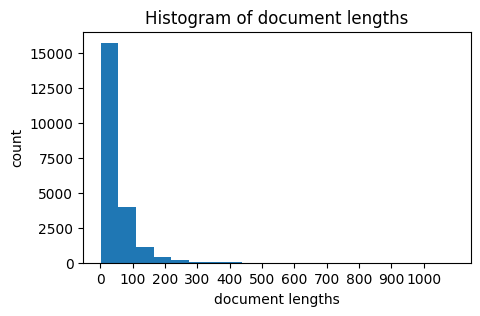

In [29]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=20)  # use 20 bins
ax.set_xticks(range(0, 1001, 100))    # set x axis ticks and range
plt.show()

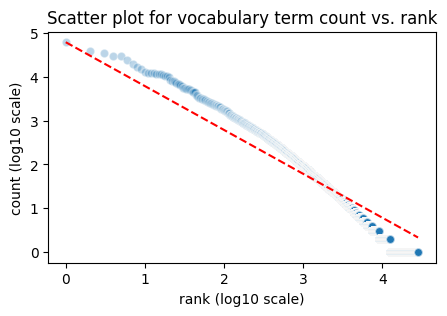

In [30]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

In [31]:
#save the files to disk
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
pickle.dump(corpus, open(corpus_file_path, 'wb'))

In [32]:
#save the raw text of reviews to disk
text_file_path = '%s/corpus_raw_text.p' % DATA_DIR
pickle.dump(reviews, open(text_file_path, 'wb'))

### Preprocess Text Data

In [33]:
#location of corpus files
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))

In [34]:
#create a summary of the preprocess
n = 10
k = 91
vocab_size = vocabulary_size(corpus)
df_tokens = tmtoolkit.corpus.tokens_table(corpus)
#print a summary of the preprocess
print('record for key', k, 'contains:')
print(corpus[k])
print('corpus vocabulary size:', vocab_size)
print('first', n, 'rows of tokens table:')
print(df_tokens[df_tokens['doc'] == k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)
corpus vocabulary size: 28241
first 10 rows of tokens table:
      doc  position   token  is_punct  is_stop   lemma  like_num    pos  tag
6511   91         0   These     False     True   these     False    DET   DT
6512   91         1   watch     False    False   watch     False   NOUN   NN
6513   91         2     has     False     True    have     False    AUX  VBZ
6514   91         3  bought     False    False     buy     False   VERB  VBN
6515   91         4     for     False     True     for     False    ADP   IN
...   ...       ...     ...       ...      ...     ...       ...    ...  ...
6608   91        97   watch     False    False   watch     False   NOUN   NN
6609   91        98     and     False     True     and     False  CCONJ   CC
6610   91        99  beauty     False    False  beauty     False   NOUN   NN
6611   91       100       .      True    False       .     False  PUNCT

In [35]:
####create an english pre-processor
####preproc = TMPreproc(corpus, language='en')
####tag the words with parts of speach
####preproc.pos_tag()
# lemmatize the words (convert to root base)
lemmatize(corpus, inplace=True)
# convert words to lowercase
to_lowercase(corpus, inplace=True)
# remove special charecters
#####preproc.remove_special_chars_in_tokens()
remove_chars(corpus, chars=punctuation, inplace=True)
# add custom stopwords to remove for urls and not
####preproc.add_stopwords(['http', 'nt'])       #####
filter_clean_tokens(corpus, remove_stopwords=True, inplace=True)
# limit words to nouns, verbs, and adjectives
filter_for_pos(corpus, search_pos=['N', 'V', 'ADJ'], inplace=True)
# remove numbers and any word shorter than 2 characters
filter_clean_tokens(corpus, remove_numbers=True, inplace=True)
filter_clean_tokens(corpus, remove_shorter_than=2, inplace=True)
# remove tokens that are fairly common
remove_common_tokens(corpus, df_threshold=0.90, inplace=True)
# remove tokens that are extreamly rare
remove_uncommon_tokens(corpus, df_threshold=0.01, inplace=True)

### Review Preprocessing of Text

In [36]:
#create a summary of a sample
def preview_sample_review(corpus, k = 0):
  samp_texty = corpus[k]
  tok = doc_tokens(corpus, with_attr=True)
  samp_token_list = tok[k]['token']
  samp_token_list_length = len(samp_token_list)

  #print a random corpus
  print('record for key', k, 'contains:')
  print(corpus[k])
  print('the text contains', samp_token_list_length, 'tokens.')
  print('sample token list:', samp_token_list[0:10])
  print()

In [37]:
#preview a couple specific lists of tokens in the corpus
preview_sample_review(corpus, k = 91)
preview_sample_review(corpus, k = 1)
preview_sample_review(corpus, k = 2000)

record for key 91 contains:
Document "91" (17 tokens, 9 token attributes, 2 document attributes)
the text contains 17 tokens.
sample token list: ['watch', 'buy', 'find', 'nike', 'get', 'small', 'woman', 'pay', 'man', 'product']

record for key 1 contains:
Document "1" (7 tokens, 9 token attributes, 2 document attributes)
the text contains 7 tokens.
sample token list: ['cute', 'fit', 'small', 'wrist', 'wear', 'love', 'watch']

record for key 2000 contains:
Document "2000" (8 tokens, 9 token attributes, 2 document attributes)
the text contains 8 tokens.
sample token list: ['great', 'shoe', 'fit', 'comfortable', 'shoe', 'recommend', 'awesome', 'price']



In [38]:
#create a summary of the preprocess
n = 10
k = 91
vocab_size = vocabulary_size(corpus)
df_tokens = tmtoolkit.corpus.tokens_table(corpus)
#print a summary of the preprocess
print('record for key', k, 'contains:')
print(corpus[k])
print('corpus vocabulary size:', vocab_size)
print('first', n, 'rows of tokens table:')
print(df_tokens[df_tokens['doc'] == k])

record for key 91 contains:
Document "91" (17 tokens, 9 token attributes, 2 document attributes)
corpus vocabulary size: 245
first 10 rows of tokens table:
      doc  position      token  is_punct  is_stop      lemma  like_num    pos  \
1300   91         0      watch     False    False      watch     False   NOUN   
1301   91         1        buy     False    False        buy     False   VERB   
1302   91         2       find     False    False       find     False   VERB   
1303   91         3       nike     False    False       Nike     False  PROPN   
1304   91         4        get     False    False        get     False   VERB   
1305   91         5      small     False    False      small     False    ADJ   
1306   91         6      woman     False    False      woman     False   NOUN   
1307   91         7        pay     False    False        pay     False   VERB   
1308   91         8        man     False    False        man     False   NOUN   
1309   91         9    product    

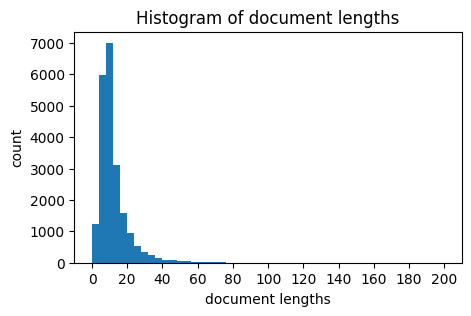

In [39]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=50)  # use 20 bins
ax.set_xticks(range(0, 201, 20))    # set x axis ticks and range
plt.show()

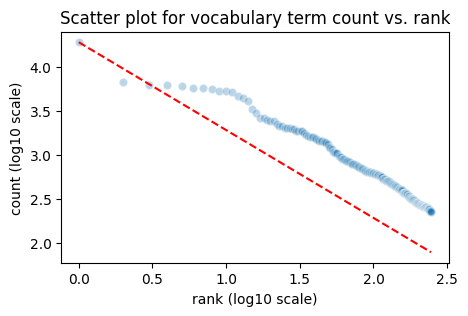

In [40]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

In [41]:
#summarize the size of the vocabulary
vocabulary_size(corpus)

245

### Save the Preprocessed Data

In [42]:
#create the document labels
doc_lbls = np.array(doc_labels(corpus))
#preview the document labels
print(doc_lbls[:10])

[0 1 2 3 4 5 6 7 8 9]


In [43]:
#create the vocabulary
vocab = np.array(vocabulary(corpus))
#preview the document labels
print(vocab[:10])

['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']


In [44]:
#create the document-term matrix (DTM)
dtm_main = dtm(corpus)
#dtm_main = scipy.sparse.csr_matrix(dtm_main)
#preview the dtm
dtm_main

<21570x245 sparse matrix of type '<class 'numpy.intc'>'
	with 212452 stored elements in Compressed Sparse Row format>

In [45]:
#save the files to disk
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

pickle.dump(corpus, open(corpus_file_path, 'wb') )
pickle.dump(doc_lbls, open(doc_labels_file_path, 'wb'))
pickle.dump(vocab, open(vocab_file_path, 'wb'))
scipy.sparse.save_npz(dtm_file_path, dtm_main)

## Model Parameter Tuning
### Import the Corpus

In [46]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_lbls = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab = pickle.load(open(vocab_file_path, 'rb'))

#preview the document labels
print('sample of document labels:', doc_lbls[:10])
print('sample of vocabulary:', vocab[:10])
print('dtm none zero count:', dtm_main.count_nonzero())

sample of document labels: [0 1 2 3 4 5 6 7 8 9]
sample of vocabulary: ['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']
dtm none zero count: 212452


In [47]:
# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False
warnings.filterwarnings('ignore')

### Model Evaluation Functions

In [48]:
#build a parameter inputs for the model using a scaling factor for eta and alpha
def build_param_inputs(kmax = 100, eta_factor = 1, alpha_factor = 1):
  #setup parameters
  const_params = {'n_iter': 500,'eta': round(0.1/eta_factor,5), 'random_state': 20191122}
  if kmax <=50:
   ks = list(range(5, kmax+1, 5))
  elif kmax <=100:
    ks = [5,10,15] + list(range(20, kmax+1, 10))
  else:
    ks = list(range(10, 100, 10)) + list(range(100, kmax+1, 20))
  varying_params = [dict(n_topics=k, alpha=round(1/(alpha_factor*k), 5)) for k in ks]
  num_trials = len(varying_params)
  #display the parameter selections
  print('[.] constant parameters:', const_params)
  print('[.] number of topics to try:', ks)
  print('[.] number of trials:', num_trials)
  print('[.] variable parameter trials:', varying_params)

  return varying_params, const_params

In [49]:
#build a parameter inputs for the model using a fixed value for eta and alpha
def build_param_inputs_fixed(kmax = 100, eta_value = .1, alpha_value = 1):
  #setup parameters
  const_params = {'n_iter': 500,'eta': eta_value, 'random_state': 20191122}
  if kmax <=50:
   ks = list(range(5, kmax+1, 5))
  elif kmax <=100:
    ks = [5,10,15] + list(range(20, kmax+1, 10))
  else:
    ks = list(range(10, 100, 10)) + list(range(100, kmax+1, 20))
  varying_params = [dict(n_topics=k, alpha=alpha_value) for k in ks]
  num_trials = len(varying_params)
  #display the parameter selections
  print('[.] constant parameters:', const_params)
  print('[.] number of topics to try:', ks)
  print('[.] number of trials:', num_trials)
  print('[.] variable parameter trials:', varying_params)

  return varying_params, const_params

In [50]:
#evaluate the model results for the model and return the performance metrics
def evaluate_model_results_custom(dtm_p, varying_p, const_p):
  #evaluate model results
  eval_results = tm_lda.evaluate_topic_models(dtm_p,
                                              varying_parameters = varying_p,
                                              constant_parameters = const_p,
                                              metric = ['arun_2010','cao_juan_2009','coherence_mimno_2011']
                                              )
  results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
  results_by_n_topics = [(x, {key: round(value, 3) for key, value in inner_dict.items()}) for x, inner_dict in results_by_n_topics]
  #display the results of the models as text
  print('[.] number of results calculated:', len(results_by_n_topics))
  print('[.] results by n topic models:', results_by_n_topics)

  return results_by_n_topics

In [51]:
#custom function to display the model results
def plot_eval_results_custom(results_by_n_topics):
  # Extract data from results_by_n_topics
  n_topics = [item[0] for item in results_by_n_topics]
  arun_2010_values = [item[1]['arun_2010'] for item in results_by_n_topics]
  cao_juan_2009_values = [item[1]['cao_juan_2009'] for item in results_by_n_topics]
  coherence_mimno_2011_values = [item[1]['coherence_mimno_2011'] for item in results_by_n_topics]

  # Create subplots with a single row and multiple columns
  fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Adjust the figure size as needed
  fs = 8

  # Plot Arun 2010 Metric
  axes[0].plot(n_topics, arun_2010_values, label='Arun 2010', marker='o')
  axes[0].set_xlabel('Number of Topics', fontsize=fs)
  axes[0].set_ylabel('Metric Value', fontsize=fs)
  axes[0].set_title('Minimize: Arun 2010', fontsize=fs)

  # Plot Cao Juan 2009 Metric
  axes[1].plot(n_topics, cao_juan_2009_values, label='Cao Juan 2009', marker='o')
  axes[1].set_xlabel('Number of Topics', fontsize=fs)
  axes[1].set_ylabel('Metric Value', fontsize=fs)
  axes[1].set_title('Minimize: Cao Juan 2009', fontsize=fs)

  # Plot Coherence Mimno 2011 Metric
  axes[2].plot(n_topics, coherence_mimno_2011_values, label='Coherence Mimno 2011', marker='o')
  axes[2].set_xlabel('Number of Topics', fontsize=fs)
  axes[2].set_ylabel('Metric Value', fontsize=fs)
  axes[2].set_title('Maximize: Coherence Mimno 2011', fontsize=fs)

  # Adjust layout spacing
  plt.tight_layout()

  # Show the plots
  plt.show()

In [52]:
#repeatable steps for completing a model evaluation with the variable parameters
def automate_test_varible_model(dtm_p, eta_list, alpha_list, kmax, output_file):
  #establish tracking metrics
  total_runs = len(eta_list) * len(alpha_list)
  all_model_runs = {}
  start_time = time.time()
  count = 0
  #iterate through all inputs for eta and alpha

  for e in eta_list:
    for a in alpha_list:
      run_code = 'eta_factor_' + str(e).zfill(4) + '__' + 'alpha_factor_' + str(a).zfill(4)
      print('running the evaluation for:', run_code)
      #build the variable params
      varying_params, const_params = build_param_inputs(kmax = kmax, eta_factor = e, alpha_factor = a)
      #build the results
      results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_p, varying_p = varying_params, const_p = const_params)
      #record the results
      all_model_runs[run_code] = results_by_n_topics
      #update on the progress and runtime
      count += 1
      current_progress = int(round(count/total_runs,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
      #plot the results
      plot_eval_results_custom(results_by_n_topics)
  #print summary of the entire run
  print('evaluation data captured for', len(all_model_runs), 'sets of parameters.')
  #save the files to disk
  eval_file_path = '%s/%s' % (DATA_DIR, output_file)
  pickle.dump(all_model_runs, open(eval_file_path, 'wb'))
  #return the results
  return all_model_runs

In [53]:
#repeatable steps for completing a model evaluation with the fixed parameters
def automate_test_fixed_model(dtm_p, eta_list, alpha_list, kmax, output_file):
  #establish tracking metrics
  total_runs = len(eta_list) * len(alpha_list)
  all_model_runs = {}
  start_time = time.time()
  count = 0
  #iterate through all inputs for eta and alpha

  for e in eta_list:
    for a in alpha_list:
      run_code = 'eta_' + str(e).zfill(4) + '__' + 'alpha_' + str(a).zfill(4)
      print('running the evaluation for:', run_code)
      #build the variable params
      varying_params, const_params = build_param_inputs_fixed(kmax = kmax, eta_value = e, alpha_value = a)
      #build the results
      results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_p, varying_p = varying_params, const_p = const_params)
      #record the results
      all_model_runs[run_code] = results_by_n_topics
      #update on the progress and runtime
      count += 1
      current_progress = int(round(count/total_runs,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
      #plot the results
      plot_eval_results_custom(results_by_n_topics)
  #print summary of the entire run
  print('evaluation data captured for', len(all_model_runs), 'sets of parameters.')
  #save the files to disk
  eval_file_path = '%s/%s' % (DATA_DIR, output_file)
  pickle.dump(all_model_runs, open(eval_file_path, 'wb'))
  #return the results
  return all_model_runs

In [54]:
#load model evaluations previously saved in a file
def load_model_evaluations(DATA_DIR, path_location):
  #location of model evaluation file files
  eval_file_path = '%s/%s' % (DATA_DIR, path_location)
  #load the model
  all_model_runs = pickle.load(open(eval_file_path, 'rb'))
  #load the keys for the models
  model_keys = list(all_model_runs.keys())
  #preview the document labels
  print('all keys:', model_keys)
  #preview a sample of the model data
  print('sample of model data:', all_model_runs[model_keys[0]])
  # return the model data
  return all_model_runs

In [55]:
#reprint the model evaluations
def print_model_evaluations(all_model_runs, limit = 1000, model_keys = None):
  if model_keys == None:
    key_list = list(all_model_runs.keys())
  else:
    key_list = model_keys
  len_to_print = min(len(key_list), limit)
  print('displaying charts for', len_to_print, 'models:\n')
  count = 0
  for key in key_list:
    print ('model key:', key)
    plot_eval_results_custom(all_model_runs[key])
    print()
    count += 1
    if count >= limit:
      break

### Round 1: Evaluate Model Options

- [evaluate_topic_models()](https://tmtoolkit.readthedocs.io/en/latest/api.html#tmtoolkit.topicmod.tm_lda.evaluate_topic_models)
- [Guide: Evaluate Topic Model](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Evaluation-of-topic-models)
- [tm_lda](https://tmtoolkit.readthedocs.io/en/latest/api.html#module-tmtoolkit.topicmod.tm_lda)

A high alpha value indicates that each document contains most of the topics and on the contrary, a lower alpha value indicates that the documents are likely to contain a fewer number of topic.

A Higher value of η indicates that the topics are likely to cover most of the words and on the contrary, lower eta value indicates that the topics are likely to contain a fewer number of words.

running the evaluation for: eta_factor_0001__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -424.795}), (10, {'arun_2010': 0.099, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -453.925}), (15, {'arun_2010': 0.127, 'cao_juan_2009': 0.257, 'coherence_mimno_2011': -472.586}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.234, 'coherence_mimno_20

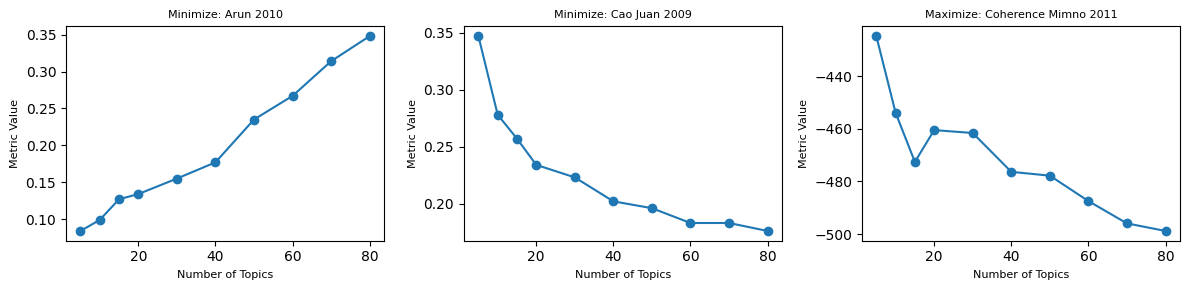

running the evaluation for: eta_factor_0001__alpha_factor_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.456, 'coherence_mimno_2011': -405.457}), (10, {'arun_2010': 0.14, 'cao_juan_2009': 0.376, 'coherence_mimno_2011': -436.9}), (15, {'arun_2010': 0.154, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -429.864}), (20, {'arun_2010': 0.171, 'cao_juan_2009': 0.33, 'coherence_mimno_2011

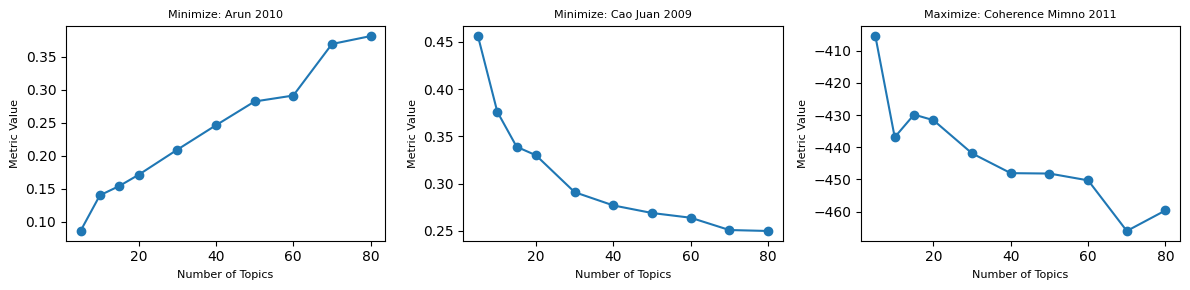

running the evaluation for: eta_factor_0001__alpha_factor_0001
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 15, 'alpha': 0.06667}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -394.849}), (10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (15, {'arun_2010': 0.178, 'cao_juan_2009': 0.426, 'coherence_mimno_2011': -423.346}), (20, {'arun_2010': 0.187, 'cao_juan_2009': 0.401, 'coherence_mim

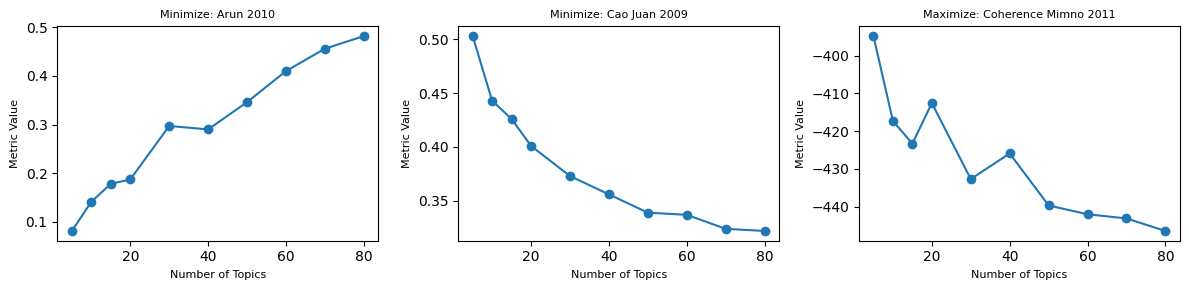

running the evaluation for: eta_factor_0001__alpha_factor_0002
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.05}, {'n_topics': 15, 'alpha': 0.03333}, {'n_topics': 20, 'alpha': 0.025}, {'n_topics': 30, 'alpha': 0.01667}, {'n_topics': 40, 'alpha': 0.0125}, {'n_topics': 50, 'alpha': 0.01}, {'n_topics': 60, 'alpha': 0.00833}, {'n_topics': 70, 'alpha': 0.00714}, {'n_topics': 80, 'alpha': 0.00625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.103, 'cao_juan_2009': 0.552, 'coherence_mimno_2011': -392.966}), (10, {'arun_2010': 0.181, 'cao_juan_2009': 0.524, 'coherence_mimno_2011': -407.828}), (15, {'arun_2010': 0.227, 'cao_juan_2009': 0.489, 'coherence_mimno_2011': -404.763}), (20, {'arun_2010': 0.288, 'cao_juan_2009': 0.477, 'coherence

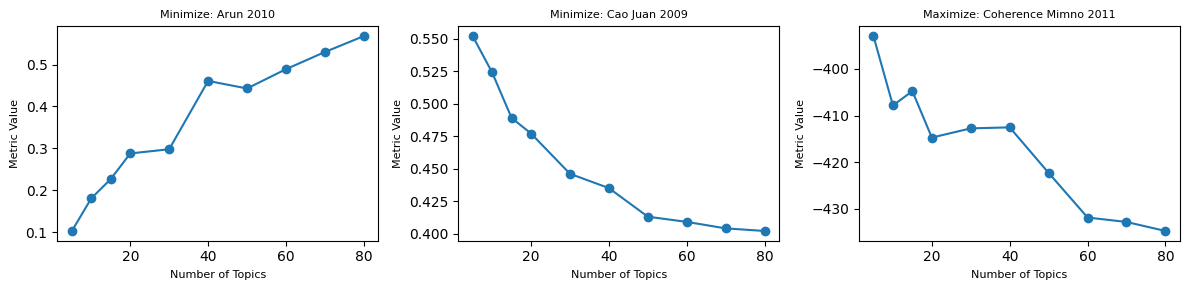

running the evaluation for: eta_factor_0001__alpha_factor_0004
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.05}, {'n_topics': 10, 'alpha': 0.025}, {'n_topics': 15, 'alpha': 0.01667}, {'n_topics': 20, 'alpha': 0.0125}, {'n_topics': 30, 'alpha': 0.00833}, {'n_topics': 40, 'alpha': 0.00625}, {'n_topics': 50, 'alpha': 0.005}, {'n_topics': 60, 'alpha': 0.00417}, {'n_topics': 70, 'alpha': 0.00357}, {'n_topics': 80, 'alpha': 0.00313}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.11, 'cao_juan_2009': 0.598, 'coherence_mimno_2011': -378.222}), (10, {'arun_2010': 0.21, 'cao_juan_2009': 0.573, 'coherence_mimno_2011': -407.221}), (15, {'arun_2010': 0.298, 'cao_juan_2009': 0.57, 'coherence_mimno_2011': -390.934}), (20, {'arun_2010': 0.4, 'cao_juan_2009': 0.536, 'coherence

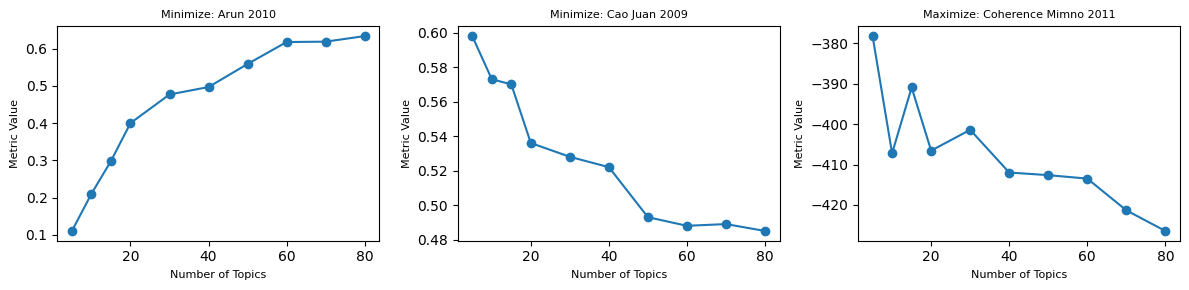

evaluation data captured for 5 sets of parameters.


In [81]:
#define the input parameters
eta_list = [1]
alpha_list = [0.25, 0.5, 1, 2, 4]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_1o0_alphaf_list.p')

running the evaluation for: eta_factor_0002__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.342, 'coherence_mimno_2011': -422.236}), (10, {'arun_2010': 0.105, 'cao_juan_2009': 0.282, 'coherence_mimno_2011': -455.67}), (15, {'arun_2010': 0.121, 'cao_juan_2009': 0.26, 'coherence_mimno_2011': -449.959}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.247, 'coherence_mimno_201

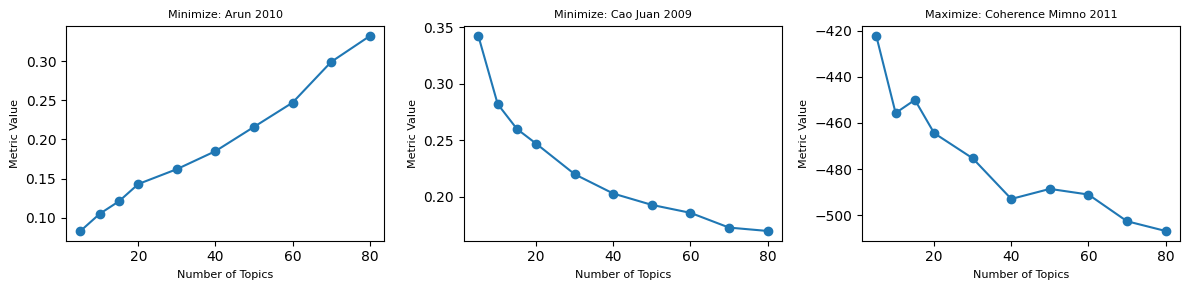

running the evaluation for: eta_factor_0002__alpha_factor_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.435, 'coherence_mimno_2011': -409.343}), (10, {'arun_2010': 0.098, 'cao_juan_2009': 0.352, 'coherence_mimno_2011': -434.087}), (15, {'arun_2010': 0.154, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -431.072}), (20, {'arun_2010': 0.177, 'cao_juan_2009': 0.323, 'coherence_mimno

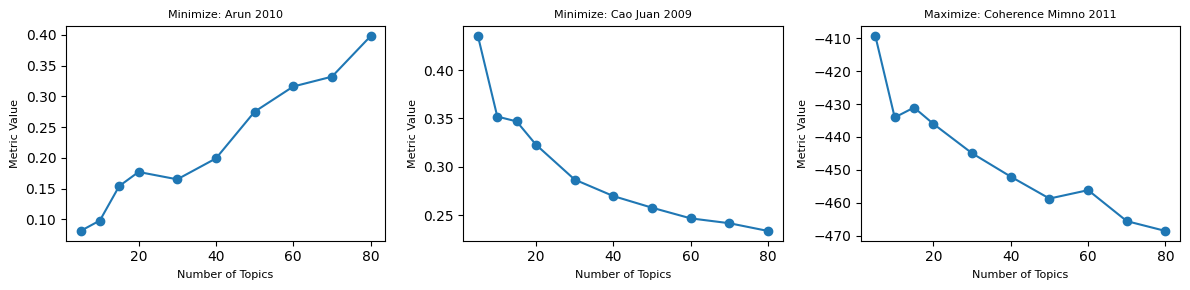

running the evaluation for: eta_factor_0002__alpha_factor_0001
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 15, 'alpha': 0.06667}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.078, 'cao_juan_2009': 0.504, 'coherence_mimno_2011': -391.668}), (10, {'arun_2010': 0.118, 'cao_juan_2009': 0.446, 'coherence_mimno_2011': -419.499}), (15, {'arun_2010': 0.182, 'cao_juan_2009': 0.424, 'coherence_mimno_2011': -414.376}), (20, {'arun_2010': 0.182, 'cao_juan_2009': 0.402, 'coherence_mi

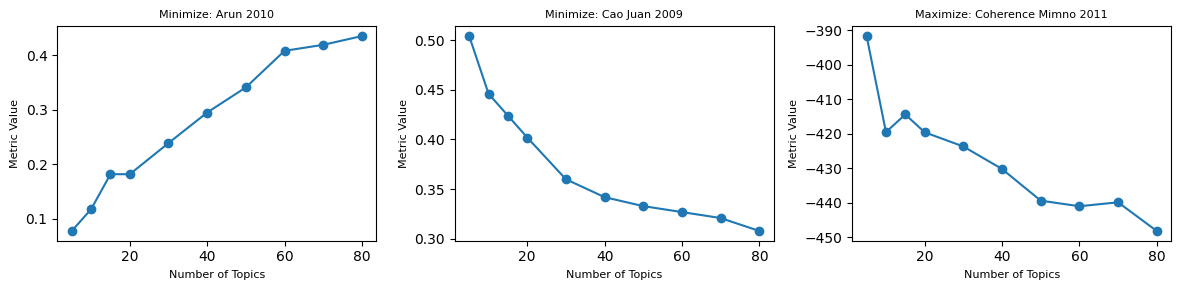

running the evaluation for: eta_factor_0002__alpha_factor_0002
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.05}, {'n_topics': 15, 'alpha': 0.03333}, {'n_topics': 20, 'alpha': 0.025}, {'n_topics': 30, 'alpha': 0.01667}, {'n_topics': 40, 'alpha': 0.0125}, {'n_topics': 50, 'alpha': 0.01}, {'n_topics': 60, 'alpha': 0.00833}, {'n_topics': 70, 'alpha': 0.00714}, {'n_topics': 80, 'alpha': 0.00625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.093, 'cao_juan_2009': 0.569, 'coherence_mimno_2011': -390.464}), (10, {'arun_2010': 0.169, 'cao_juan_2009': 0.513, 'coherence_mimno_2011': -419.28}), (15, {'arun_2010': 0.221, 'cao_juan_2009': 0.492, 'coherence_mimno_2011': -408.367}), (20, {'arun_2010': 0.215, 'cao_juan_2009': 0.467, 'coherence

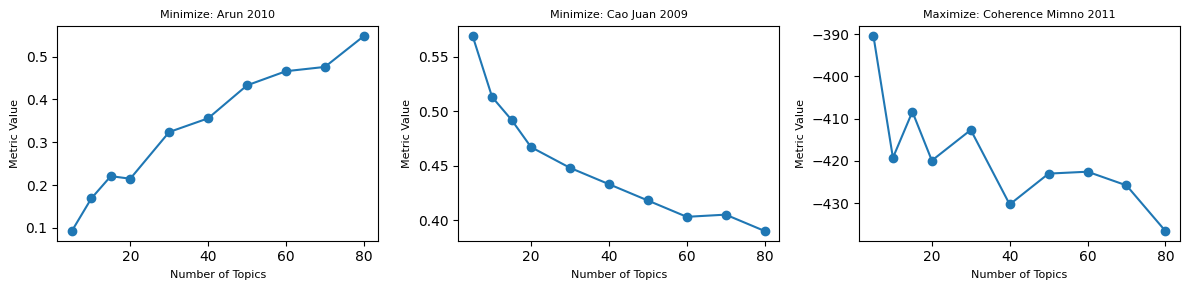

running the evaluation for: eta_factor_0002__alpha_factor_0004
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.05}, {'n_topics': 10, 'alpha': 0.025}, {'n_topics': 15, 'alpha': 0.01667}, {'n_topics': 20, 'alpha': 0.0125}, {'n_topics': 30, 'alpha': 0.00833}, {'n_topics': 40, 'alpha': 0.00625}, {'n_topics': 50, 'alpha': 0.005}, {'n_topics': 60, 'alpha': 0.00417}, {'n_topics': 70, 'alpha': 0.00357}, {'n_topics': 80, 'alpha': 0.00313}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.111, 'cao_juan_2009': 0.598, 'coherence_mimno_2011': -379.484}), (10, {'arun_2010': 0.213, 'cao_juan_2009': 0.576, 'coherence_mimno_2011': -406.082}), (15, {'arun_2010': 0.262, 'cao_juan_2009': 0.563, 'coherence_mimno_2011': -417.379}), (20, {'arun_2010': 0.321, 'cao_juan_2009': 0.541, 'coh

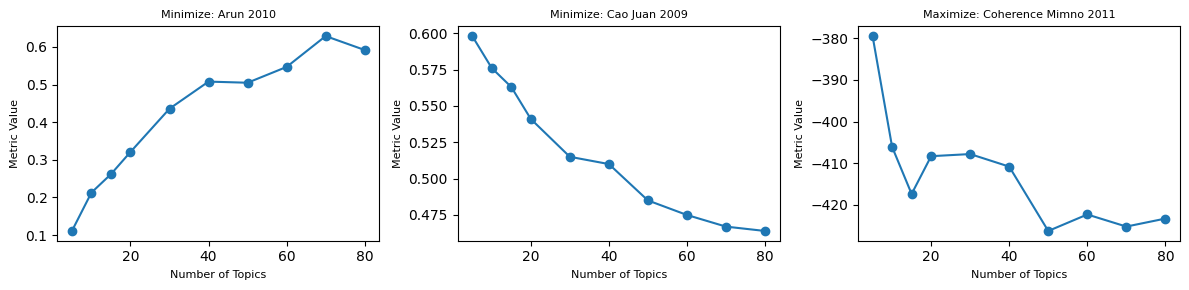

evaluation data captured for 5 sets of parameters.


In [57]:
#define the input parameters
eta_list = [2]
alpha_list = [0.25, 0.5, 1, 2, 4]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_2o0_alphaf_list.p')

running the evaluation for: eta_factor_0004__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.341, 'coherence_mimno_2011': -424.498}), (10, {'arun_2010': 0.096, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -457.704}), (15, {'arun_2010': 0.126, 'cao_juan_2009': 0.253, 'coherence_mimno_2011': -468.703}), (20, {'arun_2010': 0.126, 'cao_juan_2009': 0.233, 'coherence_mimno_

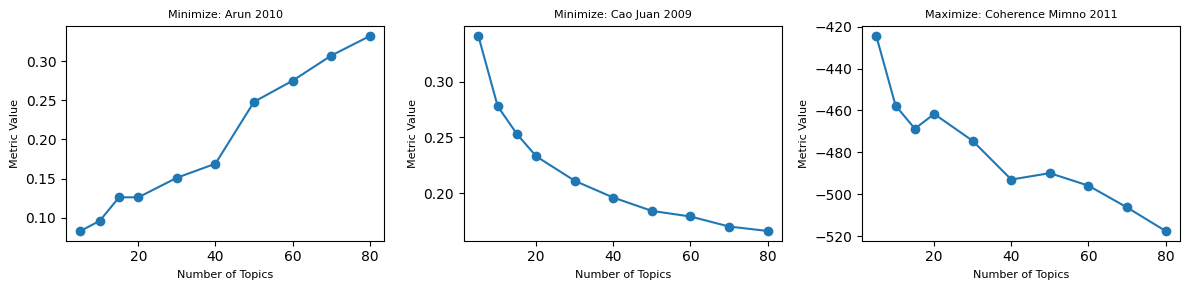

running the evaluation for: eta_factor_0004__alpha_factor_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.428, 'coherence_mimno_2011': -423.986}), (10, {'arun_2010': 0.103, 'cao_juan_2009': 0.344, 'coherence_mimno_2011': -432.362}), (15, {'arun_2010': 0.14, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -433.599}), (20, {'arun_2010': 0.19, 'cao_juan_2009': 0.336, 'coherence_mimno_

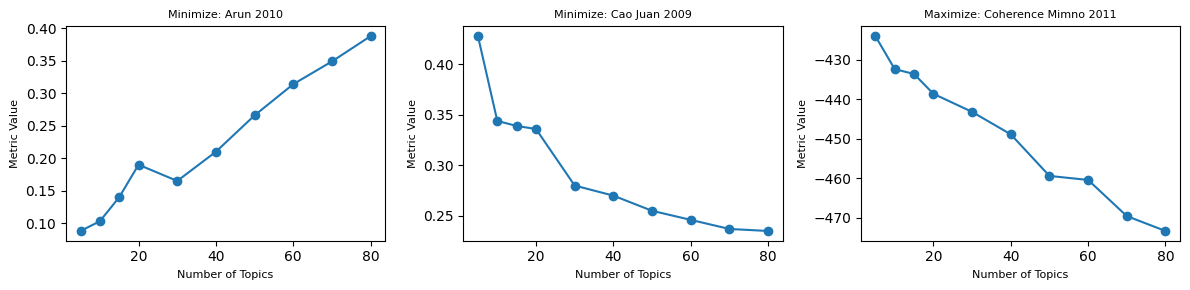

running the evaluation for: eta_factor_0004__alpha_factor_0001
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 15, 'alpha': 0.06667}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.513, 'coherence_mimno_2011': -397.315}), (10, {'arun_2010': 0.127, 'cao_juan_2009': 0.448, 'coherence_mimno_2011': -417.388}), (15, {'arun_2010': 0.165, 'cao_juan_2009': 0.417, 'coherence_mimno_2011': -418.083}), (20, {'arun_2010': 0.2, 'cao_juan_2009': 0.392, 'coherence_mim

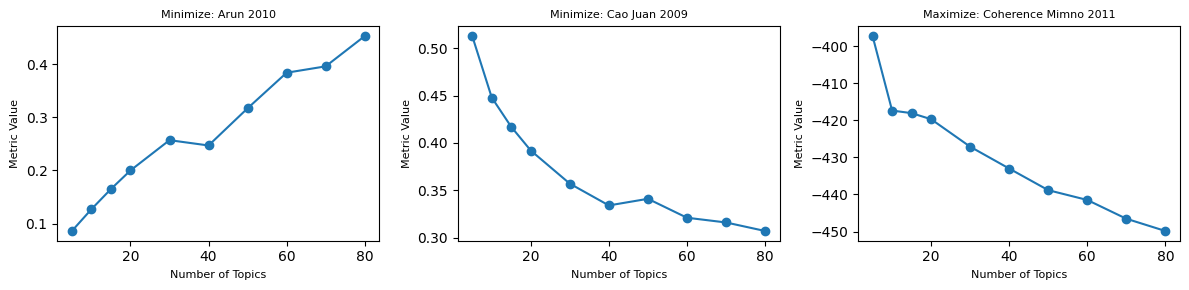

running the evaluation for: eta_factor_0004__alpha_factor_0002
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.05}, {'n_topics': 15, 'alpha': 0.03333}, {'n_topics': 20, 'alpha': 0.025}, {'n_topics': 30, 'alpha': 0.01667}, {'n_topics': 40, 'alpha': 0.0125}, {'n_topics': 50, 'alpha': 0.01}, {'n_topics': 60, 'alpha': 0.00833}, {'n_topics': 70, 'alpha': 0.00714}, {'n_topics': 80, 'alpha': 0.00625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.095, 'cao_juan_2009': 0.568, 'coherence_mimno_2011': -385.051}), (10, {'arun_2010': 0.184, 'cao_juan_2009': 0.509, 'coherence_mimno_2011': -416.705}), (15, {'arun_2010': 0.23, 'cao_juan_2009': 0.484, 'coherence_mimno_2011': -416.109}), (20, {'arun_2010': 0.241, 'cao_juan_2009': 0.469, 'coherenc

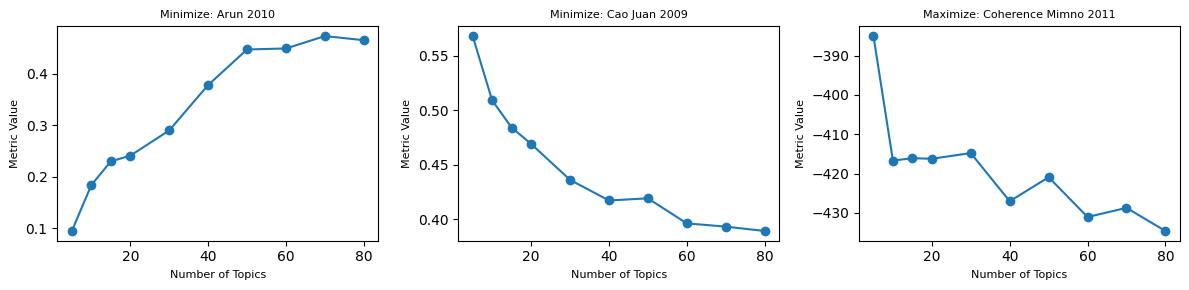

running the evaluation for: eta_factor_0004__alpha_factor_0004
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.05}, {'n_topics': 10, 'alpha': 0.025}, {'n_topics': 15, 'alpha': 0.01667}, {'n_topics': 20, 'alpha': 0.0125}, {'n_topics': 30, 'alpha': 0.00833}, {'n_topics': 40, 'alpha': 0.00625}, {'n_topics': 50, 'alpha': 0.005}, {'n_topics': 60, 'alpha': 0.00417}, {'n_topics': 70, 'alpha': 0.00357}, {'n_topics': 80, 'alpha': 0.00313}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.108, 'cao_juan_2009': 0.597, 'coherence_mimno_2011': -368.486}), (10, {'arun_2010': 0.184, 'cao_juan_2009': 0.583, 'coherence_mimno_2011': -404.528}), (15, {'arun_2010': 0.302, 'cao_juan_2009': 0.573, 'coherence_mimno_2011': -414.496}), (20, {'arun_2010': 0.295, 'cao_juan_2009': 0.54, 'coh

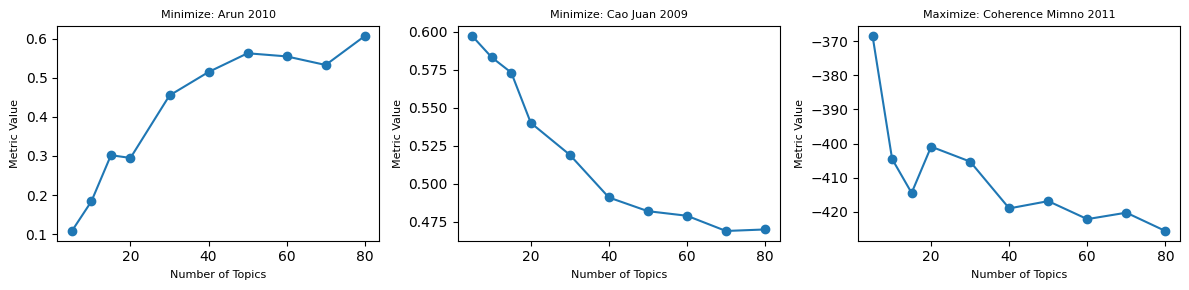

evaluation data captured for 5 sets of parameters.


In [58]:
#define the input parameters
eta_list = [4]
alpha_list = [0.25, 0.5, 1, 2, 4]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_4o0_alphaf_list.p')

running the evaluation for: eta_factor_00.5__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.351, 'coherence_mimno_2011': -432.249}), (10, {'arun_2010': 0.104, 'cao_juan_2009': 0.288, 'coherence_mimno_2011': -453.818}), (15, {'arun_2010': 0.139, 'cao_juan_2009': 0.271, 'coherence_mimno_2011': -467.014}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.251, 'coherence_mimno_20

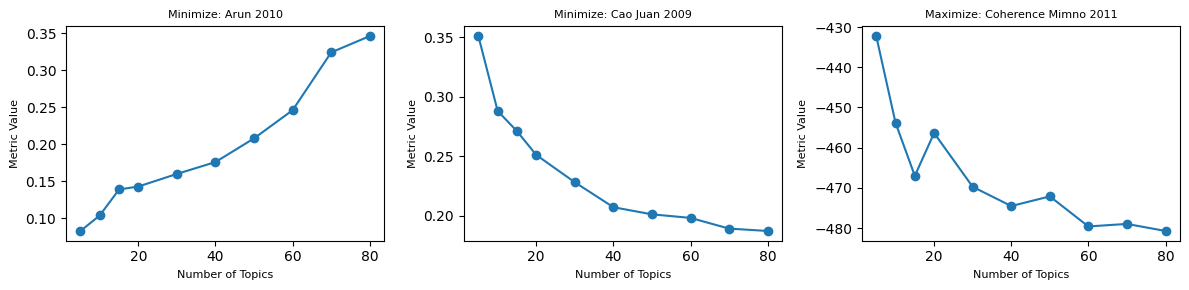

running the evaluation for: eta_factor_00.5__alpha_factor_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.46, 'coherence_mimno_2011': -405.148}), (10, {'arun_2010': 0.104, 'cao_juan_2009': 0.361, 'coherence_mimno_2011': -436.199}), (15, {'arun_2010': 0.149, 'cao_juan_2009': 0.352, 'coherence_mimno_2011': -430.788}), (20, {'arun_2010': 0.17, 'cao_juan_2009': 0.327, 'coherence_mimno_20

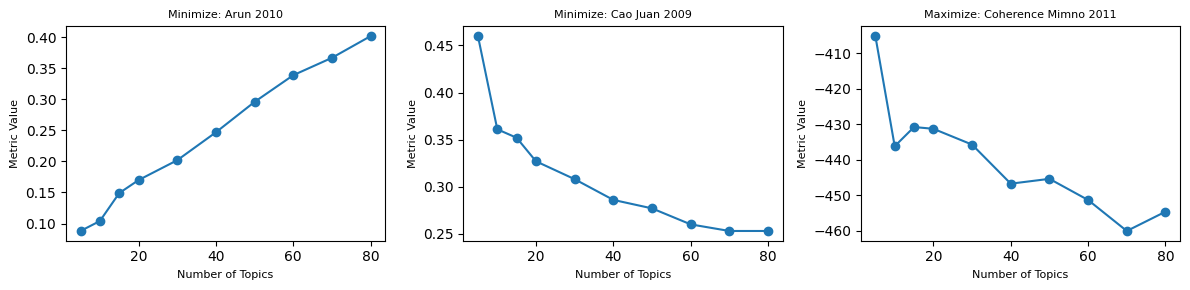

running the evaluation for: eta_factor_00.5__alpha_factor_0001
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 15, 'alpha': 0.06667}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.514, 'coherence_mimno_2011': -395.027}), (10, {'arun_2010': 0.167, 'cao_juan_2009': 0.453, 'coherence_mimno_2011': -419.63}), (15, {'arun_2010': 0.167, 'cao_juan_2009': 0.433, 'coherence_mimno_2011': -418.231}), (20, {'arun_2010': 0.205, 'cao_juan_2009': 0.41, 'coherence_mimno

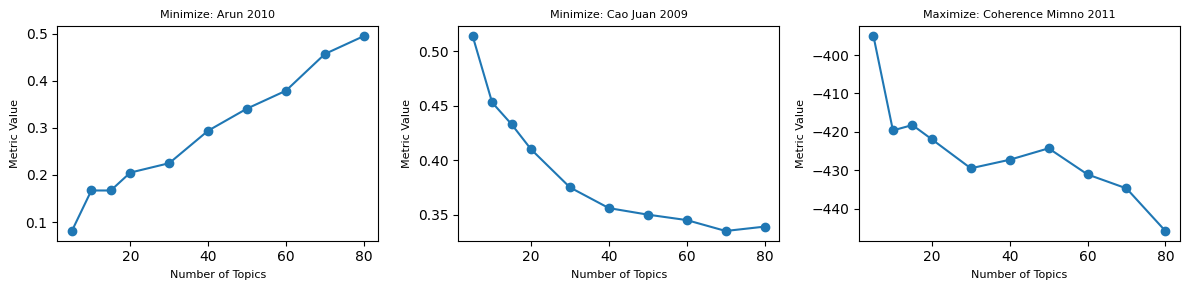

running the evaluation for: eta_factor_00.5__alpha_factor_0002
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.05}, {'n_topics': 15, 'alpha': 0.03333}, {'n_topics': 20, 'alpha': 0.025}, {'n_topics': 30, 'alpha': 0.01667}, {'n_topics': 40, 'alpha': 0.0125}, {'n_topics': 50, 'alpha': 0.01}, {'n_topics': 60, 'alpha': 0.00833}, {'n_topics': 70, 'alpha': 0.00714}, {'n_topics': 80, 'alpha': 0.00625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.098, 'cao_juan_2009': 0.567, 'coherence_mimno_2011': -378.837}), (10, {'arun_2010': 0.213, 'cao_juan_2009': 0.528, 'coherence_mimno_2011': -412.602}), (15, {'arun_2010': 0.23, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -410.237}), (20, {'arun_2010': 0.251, 'cao_juan_2009': 0.481, 'coherence_

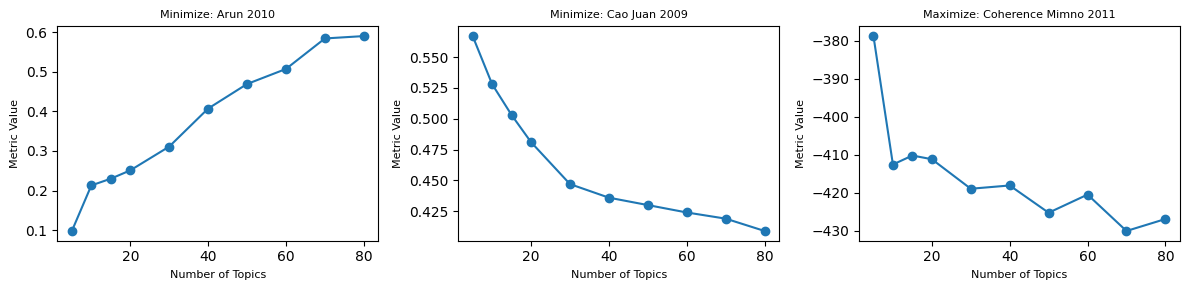

running the evaluation for: eta_factor_00.5__alpha_factor_0004
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.05}, {'n_topics': 10, 'alpha': 0.025}, {'n_topics': 15, 'alpha': 0.01667}, {'n_topics': 20, 'alpha': 0.0125}, {'n_topics': 30, 'alpha': 0.00833}, {'n_topics': 40, 'alpha': 0.00625}, {'n_topics': 50, 'alpha': 0.005}, {'n_topics': 60, 'alpha': 0.00417}, {'n_topics': 70, 'alpha': 0.00357}, {'n_topics': 80, 'alpha': 0.00313}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.113, 'cao_juan_2009': 0.599, 'coherence_mimno_2011': -375.265}), (10, {'arun_2010': 0.223, 'cao_juan_2009': 0.569, 'coherence_mimno_2011': -397.809}), (15, {'arun_2010': 0.271, 'cao_juan_2009': 0.56, 'coherence_mimno_2011': -393.718}), (20, {'arun_2010': 0.32, 'cao_juan_2009': 0.54, 'coheren

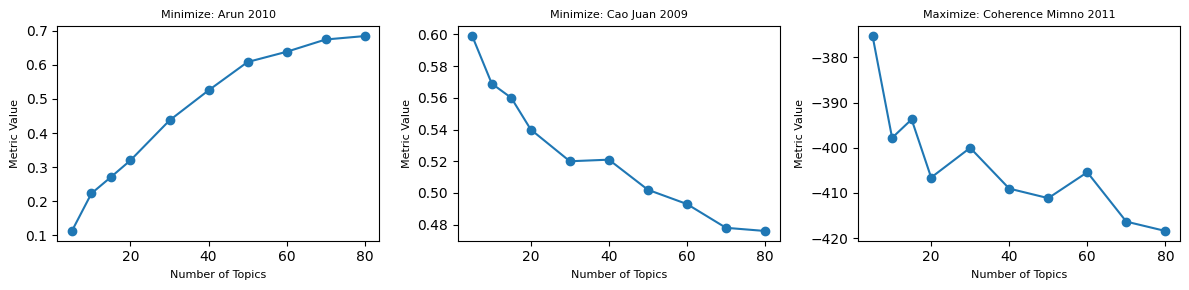

evaluation data captured for 5 sets of parameters.


In [59]:
#define the input parameters
eta_list = [0.5]
alpha_list = [0.25, 0.5, 1, 2, 4]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_0o5_alphaf_list.p')

running the evaluation for: eta_factor_0001__alpha_factor_0.125
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.6}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 15, 'alpha': 0.53333}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.26667}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.16}, {'n_topics': 60, 'alpha': 0.13333}, {'n_topics': 70, 'alpha': 0.11429}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.042, 'cao_juan_2009': 0.239, 'coherence_mimno_2011': -451.698}), (10, {'arun_2010': 0.084, 'cao_juan_2009': 0.205, 'coherence_mimno_2011': -477.327}), (15, {'arun_2010': 0.127, 'cao_juan_2009': 0.188, 'coherence_mimno_2011': -492.307}), (20, {'arun_2010': 0.135, 'cao_juan_2009': 0.166, 'coherence_mimno_20

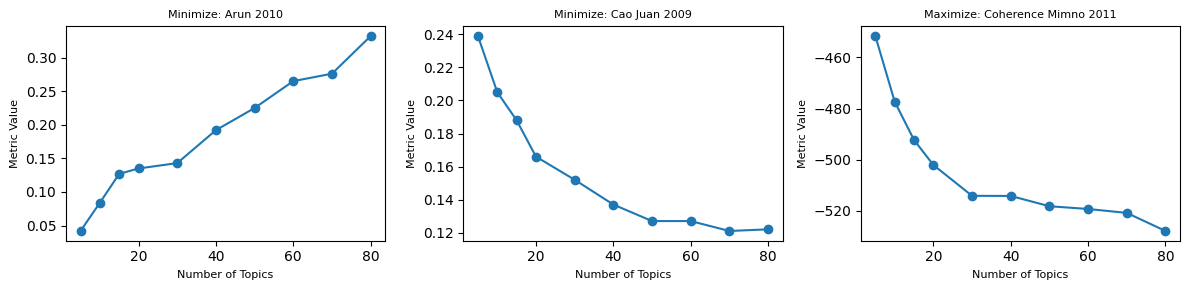

running the evaluation for: eta_factor_0001__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -424.795}), (10, {'arun_2010': 0.099, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -453.925}), (15, {'arun_2010': 0.127, 'cao_juan_2009': 0.257, 'coherence_mimno_2011': -472.586}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.234, 'coherence_mimno_20

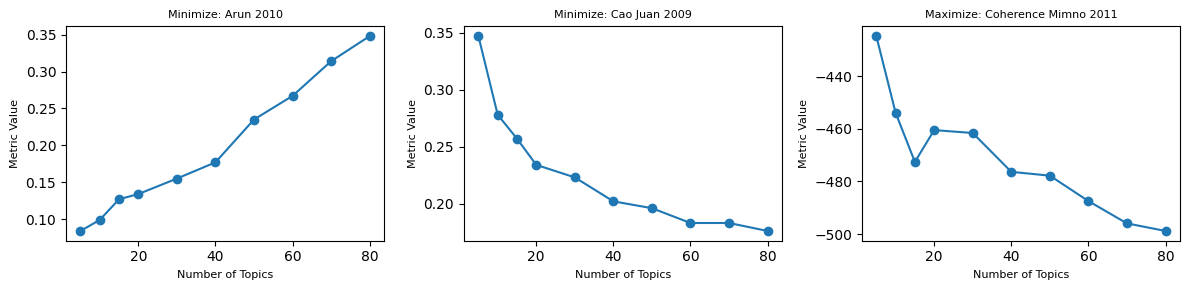

running the evaluation for: eta_factor_0001__alpha_factor_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.456, 'coherence_mimno_2011': -405.457}), (10, {'arun_2010': 0.14, 'cao_juan_2009': 0.376, 'coherence_mimno_2011': -436.9}), (15, {'arun_2010': 0.154, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -429.864}), (20, {'arun_2010': 0.171, 'cao_juan_2009': 0.33, 'coherence_mimno_2011

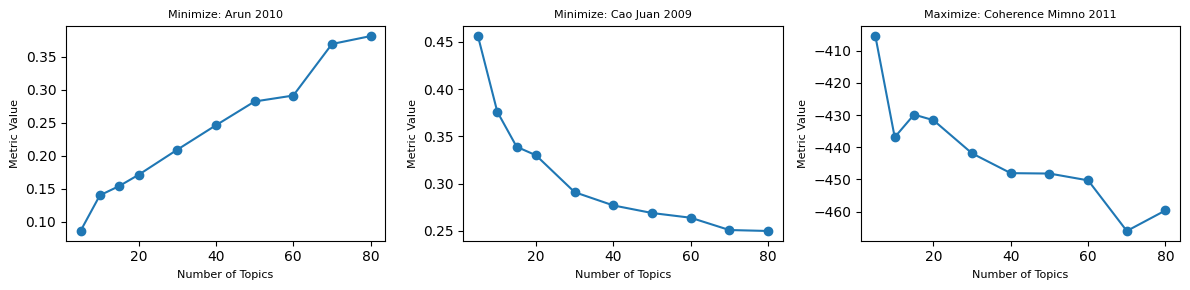

evaluation data captured for 3 sets of parameters.


In [60]:
#define the input parameters
eta_list = [1]
alpha_list = [0.125, 0.25, 0.5]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_1o0_alphaf_list_r2.p')

After reviewing many performance charts, a pattern emerged that an alpha_factor of 0.25 and 30 topics appers to perfrom well. There is more abiguity around what should be selected for eta. This will be explored in more detail in round 2.

### Round 2: Evaluate Model Options

running the evaluation for: eta_factor_0.125__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.8, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.085, 'cao_juan_2009': 0.361, 'coherence_mimno_2011': -426.406}), (10, {'arun_2010': 0.103, 'cao_juan_2009': 0.288, 'coherence_mimno_2011': -450.155}), (15, {'arun_2010': 0.146, 'cao_juan_2009': 0.28, 'coherence_mimno_2011': -449.518}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.263, 'coherence_mimno_20

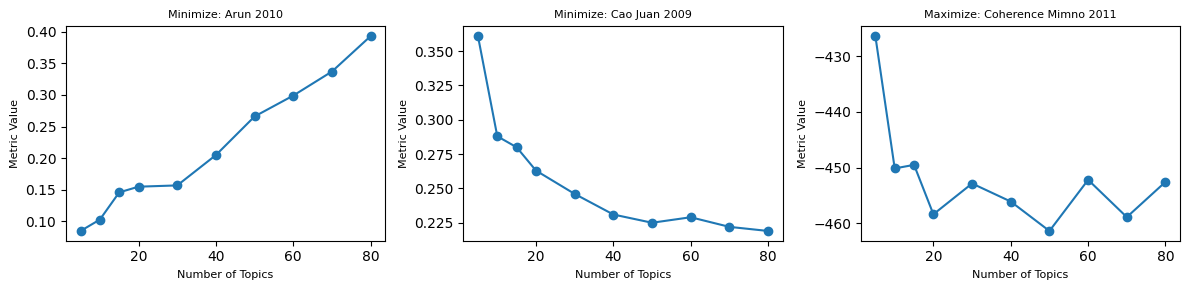

running the evaluation for: eta_factor_0.25__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.354, 'coherence_mimno_2011': -431.614}), (10, {'arun_2010': 0.1, 'cao_juan_2009': 0.277, 'coherence_mimno_2011': -455.086}), (15, {'arun_2010': 0.128, 'cao_juan_2009': 0.263, 'coherence_mimno_2011': -462.328}), (20, {'arun_2010': 0.145, 'cao_juan_2009': 0.25, 'coherence_mimno_2011'

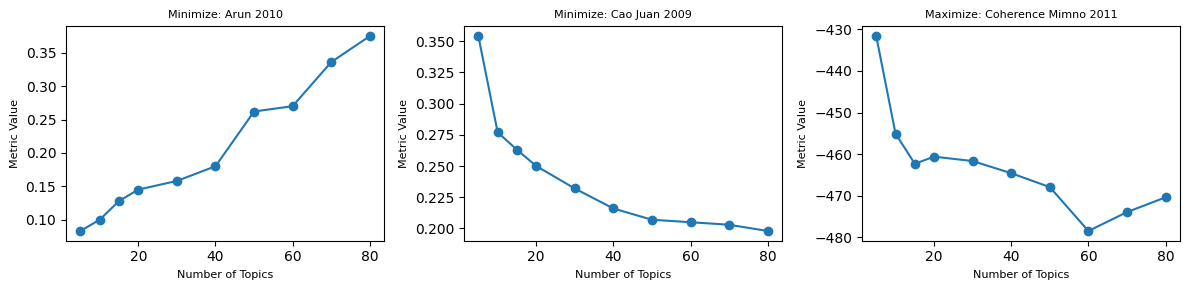

running the evaluation for: eta_factor_00.5__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.2, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.351, 'coherence_mimno_2011': -432.249}), (10, {'arun_2010': 0.104, 'cao_juan_2009': 0.288, 'coherence_mimno_2011': -453.818}), (15, {'arun_2010': 0.139, 'cao_juan_2009': 0.271, 'coherence_mimno_2011': -467.014}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.251, 'coherence_mimno_20

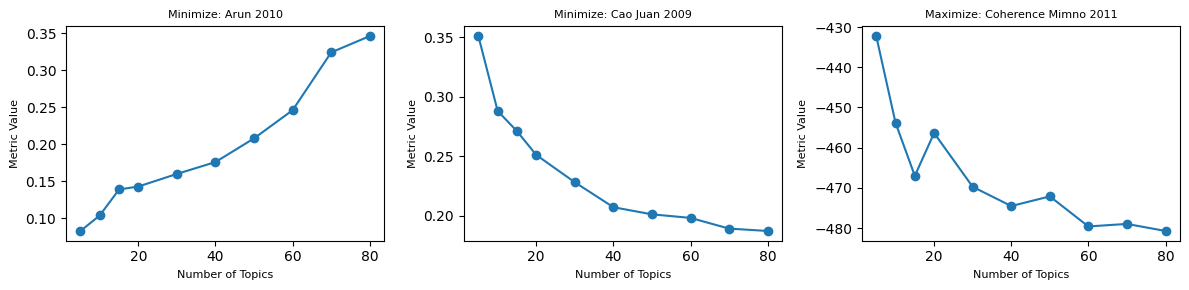

running the evaluation for: eta_factor_0001__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -424.795}), (10, {'arun_2010': 0.099, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -453.925}), (15, {'arun_2010': 0.127, 'cao_juan_2009': 0.257, 'coherence_mimno_2011': -472.586}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.234, 'coherence_mimno_20

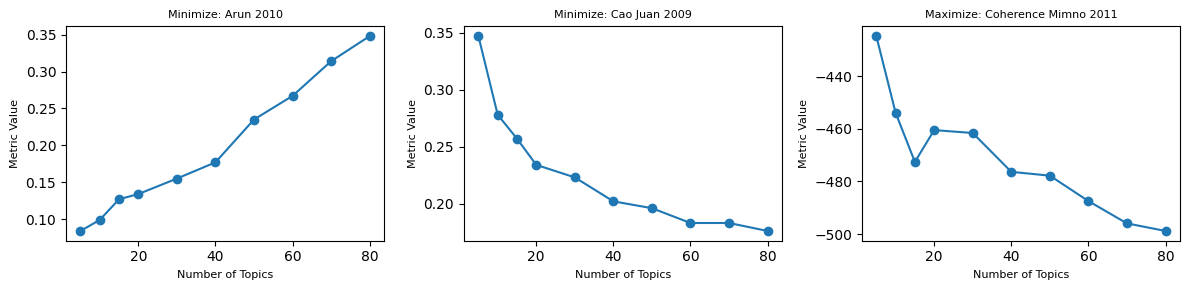

running the evaluation for: eta_factor_0002__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.342, 'coherence_mimno_2011': -422.236}), (10, {'arun_2010': 0.105, 'cao_juan_2009': 0.282, 'coherence_mimno_2011': -455.67}), (15, {'arun_2010': 0.121, 'cao_juan_2009': 0.26, 'coherence_mimno_2011': -449.959}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.247, 'coherence_mimno_201

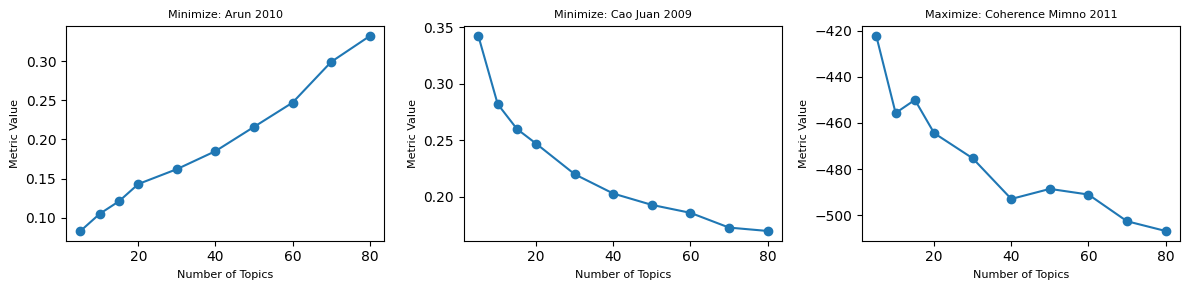

running the evaluation for: eta_factor_0004__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.025, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.341, 'coherence_mimno_2011': -424.498}), (10, {'arun_2010': 0.096, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -457.704}), (15, {'arun_2010': 0.126, 'cao_juan_2009': 0.253, 'coherence_mimno_2011': -468.703}), (20, {'arun_2010': 0.126, 'cao_juan_2009': 0.233, 'coherence_mimno_

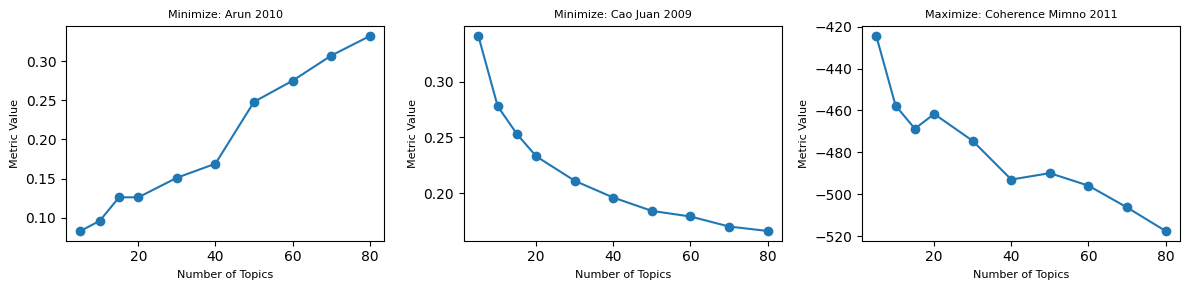

running the evaluation for: eta_factor_0008__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.0125, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.085, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -433.81}), (10, {'arun_2010': 0.094, 'cao_juan_2009': 0.275, 'coherence_mimno_2011': -467.407}), (15, {'arun_2010': 0.12, 'cao_juan_2009': 0.246, 'coherence_mimno_2011': -463.695}), (20, {'arun_2010': 0.147, 'cao_juan_2009': 0.232, 'coherence_mimno_2

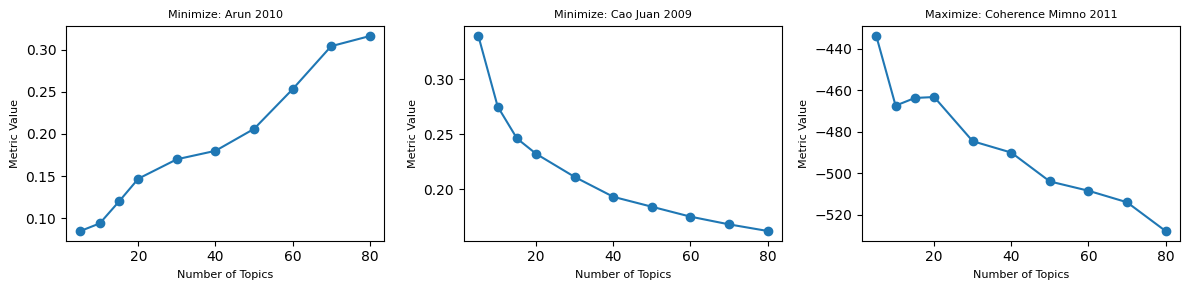

evaluation data captured for 7 sets of parameters.


In [61]:
#define the input parameters
eta_list = [0.125, 0.25, 0.5, 1, 2, 4, 8]
alpha_list = [0.25]
#eta_list   = [0.5, 1, 2, 4, 8]
#alpha_list = [0.25, 0.5, 1, 2, 4]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_list_r2_alphaf_0o25.p')

running the evaluation for: eta_factor_00.2__alpha_factor_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 15, 'alpha': 0.33333}, {'n_topics': 20, 'alpha': 0.25}, {'n_topics': 30, 'alpha': 0.16667}, {'n_topics': 40, 'alpha': 0.125}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.08333}, {'n_topics': 70, 'alpha': 0.07143}, {'n_topics': 80, 'alpha': 0.0625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.077, 'cao_juan_2009': 0.327, 'coherence_mimno_2011': -434.767}), (10, {'arun_2010': 0.1, 'cao_juan_2009': 0.263, 'coherence_mimno_2011': -479.289}), (15, {'arun_2010': 0.129, 'cao_juan_2009': 0.243, 'coherence_mimno_2011': -469.194}), (20, {'arun_2010': 0.148, 'cao_juan_2009': 0.234, 'coherence_mimno_

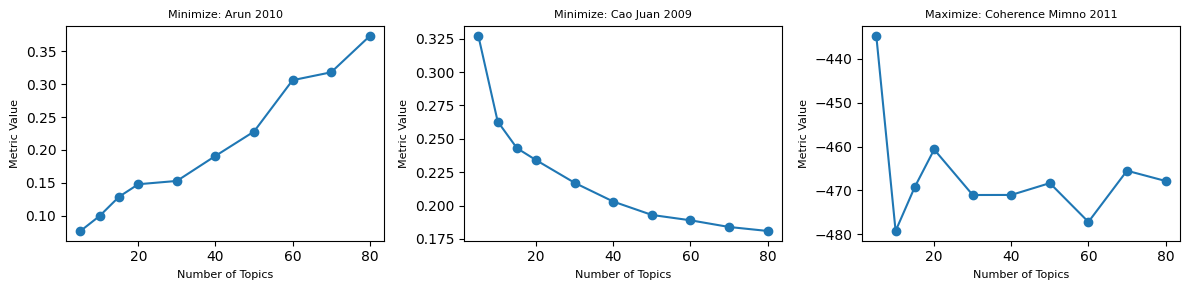

running the evaluation for: eta_factor_00.2__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.357, 'coherence_mimno_2011': -433.219}), (10, {'arun_2010': 0.107, 'cao_juan_2009': 0.291, 'coherence_mimno_2011': -469.945}), (15, {'arun_2010': 0.133, 'cao_juan_2009': 0.268, 'coherence_mimno_2011': -455.295}), (20, {'arun_2010': 0.14, 'cao_juan_2009': 0.255, 'coherence_mimno_201

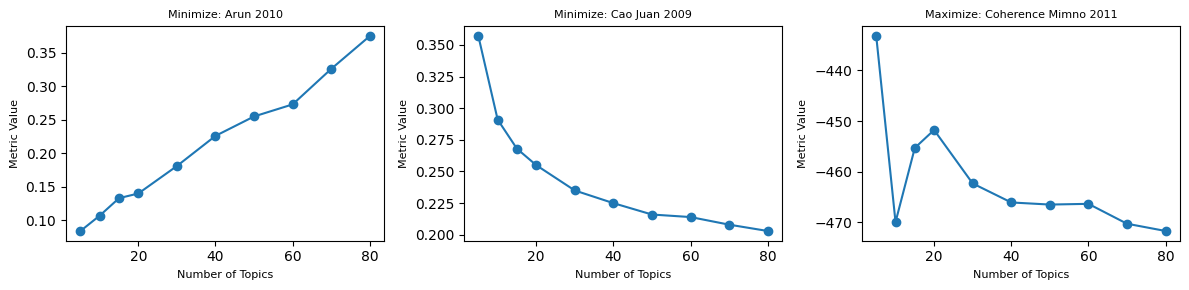

running the evaluation for: eta_factor_00.2__alpha_factor_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.66667}, {'n_topics': 10, 'alpha': 0.33333}, {'n_topics': 15, 'alpha': 0.22222}, {'n_topics': 20, 'alpha': 0.16667}, {'n_topics': 30, 'alpha': 0.11111}, {'n_topics': 40, 'alpha': 0.08333}, {'n_topics': 50, 'alpha': 0.06667}, {'n_topics': 60, 'alpha': 0.05556}, {'n_topics': 70, 'alpha': 0.04762}, {'n_topics': 80, 'alpha': 0.04167}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.386, 'coherence_mimno_2011': -423.571}), (10, {'arun_2010': 0.134, 'cao_juan_2009': 0.32, 'coherence_mimno_2011': -451.453}), (15, {'arun_2010': 0.131, 'cao_juan_2009': 0.297, 'coherence_mimno_2011': -441.713}), (20, {'arun_2010': 0.154, 'cao_juan_2009': 0.277

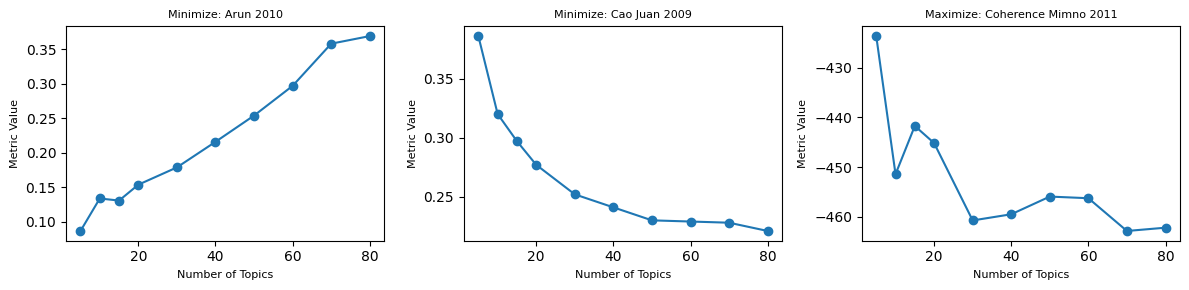

running the evaluation for: eta_factor_0.25__alpha_factor_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 15, 'alpha': 0.33333}, {'n_topics': 20, 'alpha': 0.25}, {'n_topics': 30, 'alpha': 0.16667}, {'n_topics': 40, 'alpha': 0.125}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.08333}, {'n_topics': 70, 'alpha': 0.07143}, {'n_topics': 80, 'alpha': 0.0625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.054, 'cao_juan_2009': 0.277, 'coherence_mimno_2011': -421.7}), (10, {'arun_2010': 0.121, 'cao_juan_2009': 0.264, 'coherence_mimno_2011': -469.029}), (15, {'arun_2010': 0.151, 'cao_juan_2009': 0.244, 'coherence_mimno_2011': -475.544}), (20, {'arun_2010': 0.144, 'cao_juan_2009': 0.232, 'coherence_mimno_

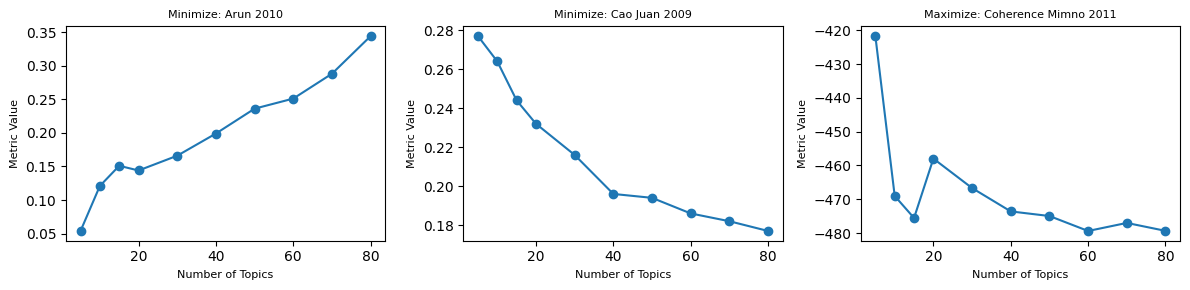

running the evaluation for: eta_factor_0.25__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.354, 'coherence_mimno_2011': -431.614}), (10, {'arun_2010': 0.1, 'cao_juan_2009': 0.277, 'coherence_mimno_2011': -455.086}), (15, {'arun_2010': 0.128, 'cao_juan_2009': 0.263, 'coherence_mimno_2011': -462.328}), (20, {'arun_2010': 0.145, 'cao_juan_2009': 0.25, 'coherence_mimno_2011'

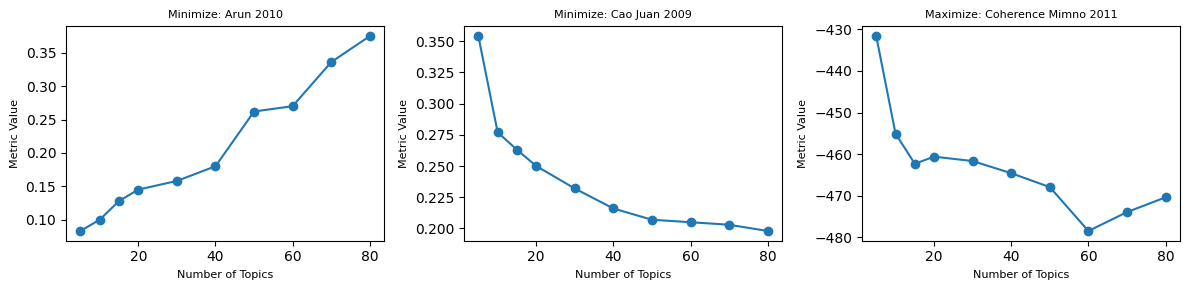

running the evaluation for: eta_factor_0.25__alpha_factor_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.66667}, {'n_topics': 10, 'alpha': 0.33333}, {'n_topics': 15, 'alpha': 0.22222}, {'n_topics': 20, 'alpha': 0.16667}, {'n_topics': 30, 'alpha': 0.11111}, {'n_topics': 40, 'alpha': 0.08333}, {'n_topics': 50, 'alpha': 0.06667}, {'n_topics': 60, 'alpha': 0.05556}, {'n_topics': 70, 'alpha': 0.04762}, {'n_topics': 80, 'alpha': 0.04167}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.383, 'coherence_mimno_2011': -418.115}), (10, {'arun_2010': 0.115, 'cao_juan_2009': 0.321, 'coherence_mimno_2011': -439.857}), (15, {'arun_2010': 0.155, 'cao_juan_2009': 0.292, 'coherence_mimno_2011': -467.79}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.262

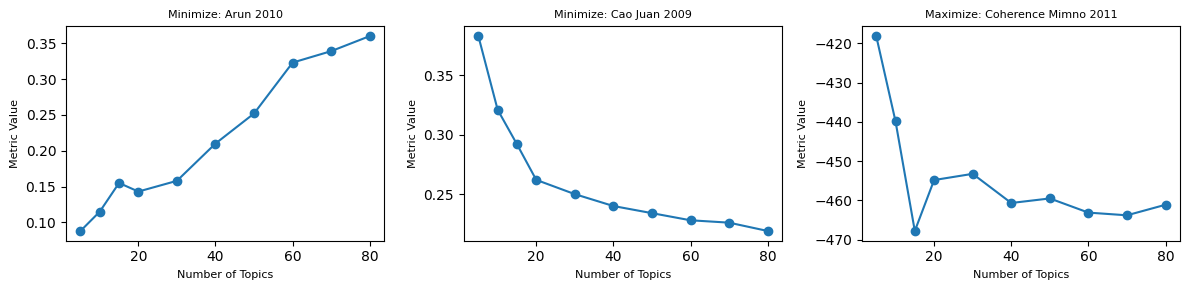

running the evaluation for: eta_factor_00.3__alpha_factor_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.33333, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 15, 'alpha': 0.33333}, {'n_topics': 20, 'alpha': 0.25}, {'n_topics': 30, 'alpha': 0.16667}, {'n_topics': 40, 'alpha': 0.125}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.08333}, {'n_topics': 70, 'alpha': 0.07143}, {'n_topics': 80, 'alpha': 0.0625}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.08, 'cao_juan_2009': 0.331, 'coherence_mimno_2011': -428.368}), (10, {'arun_2010': 0.091, 'cao_juan_2009': 0.27, 'coherence_mimno_2011': -478.567}), (15, {'arun_2010': 0.13, 'cao_juan_2009': 0.237, 'coherence_mimno_2011': -463.579}), (20, {'arun_2010': 0.14, 'cao_juan_2009': 0.225, 'coherence_mimn

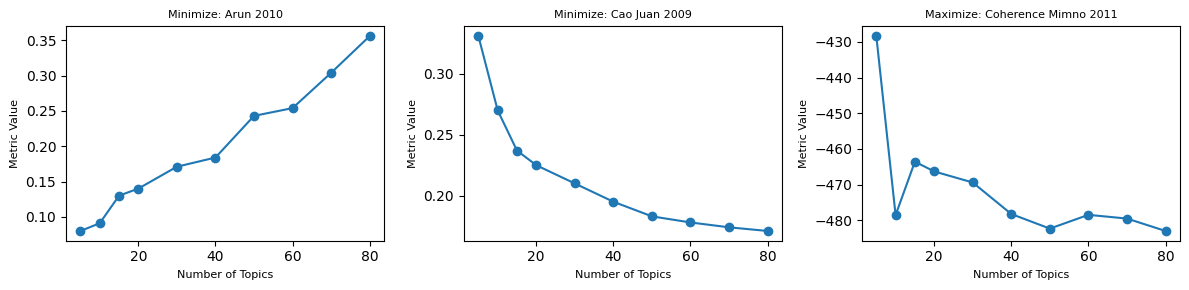

running the evaluation for: eta_factor_00.3__alpha_factor_0.25
[.] constant parameters: {'n_iter': 500, 'eta': 0.33333, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 15, 'alpha': 0.26667}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.08}, {'n_topics': 60, 'alpha': 0.06667}, {'n_topics': 70, 'alpha': 0.05714}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.352, 'coherence_mimno_2011': -435.172}), (10, {'arun_2010': 0.109, 'cao_juan_2009': 0.293, 'coherence_mimno_2011': -458.527}), (15, {'arun_2010': 0.125, 'cao_juan_2009': 0.276, 'coherence_mimno_2011': -462.458}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.254, 'coherence_mimn

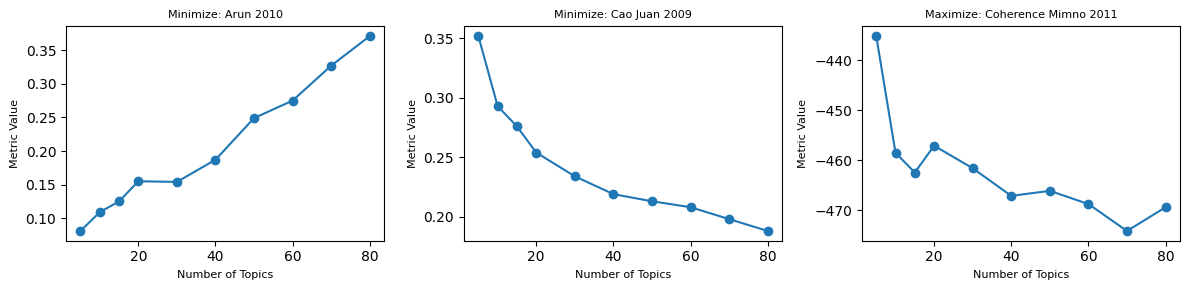

running the evaluation for: eta_factor_00.3__alpha_factor_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.33333, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.66667}, {'n_topics': 10, 'alpha': 0.33333}, {'n_topics': 15, 'alpha': 0.22222}, {'n_topics': 20, 'alpha': 0.16667}, {'n_topics': 30, 'alpha': 0.11111}, {'n_topics': 40, 'alpha': 0.08333}, {'n_topics': 50, 'alpha': 0.06667}, {'n_topics': 60, 'alpha': 0.05556}, {'n_topics': 70, 'alpha': 0.04762}, {'n_topics': 80, 'alpha': 0.04167}]
[.] number of results calculated: 10
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.38, 'coherence_mimno_2011': -423.725}), (10, {'arun_2010': 0.108, 'cao_juan_2009': 0.316, 'coherence_mimno_2011': -442.341}), (15, {'arun_2010': 0.164, 'cao_juan_2009': 0.308, 'coherence_mimno_2011': -455.6}), (20, {'arun_2010': 0.162, 'cao_juan_2009': 0.2

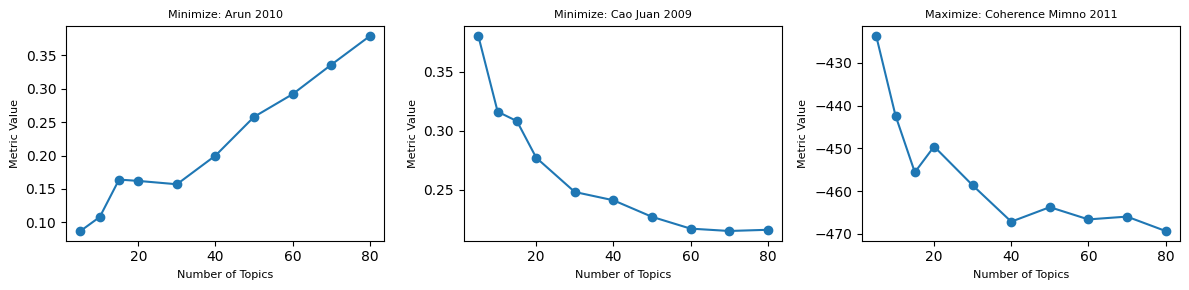

evaluation data captured for 9 sets of parameters.


In [62]:
#define the input parameters
eta_list = [0.20,0.25,0.30]
alpha_list = [0.20,0.25,0.30]
kmax = 80
# run the function
all_model_runs = automate_test_varible_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_vary_ae_etaf_list_r2_alphaf_list_r2.p')

Main parameter sets of interest:
- eta_factor_0001__alpha_factor_0.25 - 30 topics
- eta_factor_0.25__alpha_factor_0.25 - 30 topics
- eta_factor_0.25__alpha_factor_00.3
### Round 3: Strategic Model Options

[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.13333}, {'n_topics': 10, 'alpha': 0.13333}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.13333}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.13333}, {'n_topics': 50, 'alpha': 0.13333}, {'n_topics': 60, 'alpha': 0.13333}]
[.] number of results calculated: 8
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.551, 'coherence_mimno_2011': -387.867}), (10, {'arun_2010': 0.121, 'cao_juan_2009': 0.416, 'coherence_mimno_2011': -424.995}), (15, {'arun_2010': 0.154, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -429.864}), (20, {'arun_2010': 0.137, 'cao_juan_2009': 0.289, 'coherence_mimno_2011': -445.159}), (30, {'arun_2010': 0.155, 'cao_juan_2009': 0.223, 'coherence_mimno_2011': -461.601}), (40, {'arun_2010': 0

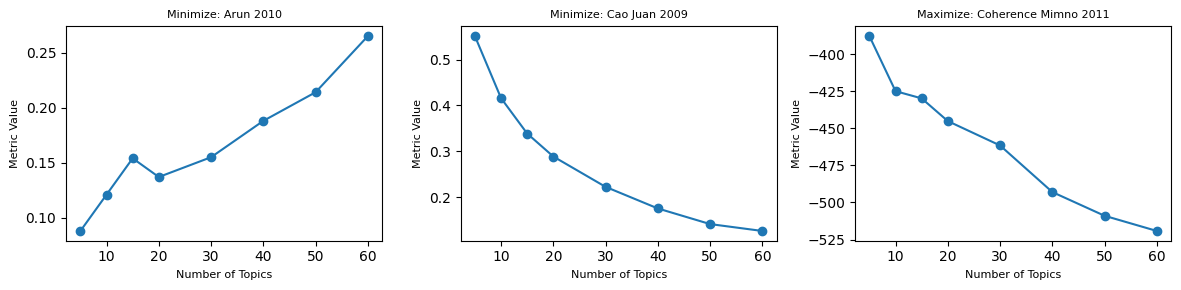

In [64]:
#model parameters
eta_factor = 1; alpha_factor = 0.25; k = 30
#claculate parameters
eta = round(0.1/eta_factor,5)
alpha = round(1/(alpha_factor*k), 5)
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 60, eta_value = eta, alpha_value = alpha)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.11111}, {'n_topics': 10, 'alpha': 0.11111}, {'n_topics': 15, 'alpha': 0.11111}, {'n_topics': 20, 'alpha': 0.11111}, {'n_topics': 30, 'alpha': 0.11111}, {'n_topics': 40, 'alpha': 0.11111}, {'n_topics': 50, 'alpha': 0.11111}, {'n_topics': 60, 'alpha': 0.11111}]
[.] number of results calculated: 8
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.56, 'coherence_mimno_2011': -379.73}), (10, {'arun_2010': 0.132, 'cao_juan_2009': 0.431, 'coherence_mimno_2011': -424.082}), (15, {'arun_2010': 0.144, 'cao_juan_2009': 0.37, 'coherence_mimno_2011': -428.134}), (20, {'arun_2010': 0.163, 'cao_juan_2009': 0.312, 'coherence_mimno_2011': -431.683}), (30, {'arun_2010': 0.162, 'cao_juan_2009': 0.237, 'coherence_mimno_2011': -462.157}), (40, {'arun_2010': 0.17

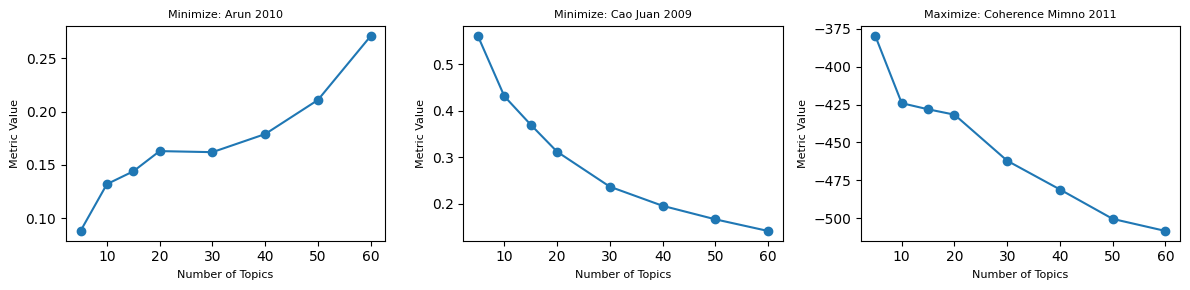

In [65]:
#model parameters
eta_factor = 1; alpha_factor = 0.30; k = 30
#claculate parameters
eta = round(0.1/eta_factor,5)
alpha = round(1/(alpha_factor*k), 5)
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 60, eta_value = eta, alpha_value = alpha)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.13333}, {'n_topics': 10, 'alpha': 0.13333}, {'n_topics': 15, 'alpha': 0.13333}, {'n_topics': 20, 'alpha': 0.13333}, {'n_topics': 30, 'alpha': 0.13333}, {'n_topics': 40, 'alpha': 0.13333}, {'n_topics': 50, 'alpha': 0.13333}, {'n_topics': 60, 'alpha': 0.13333}]
[.] number of results calculated: 8
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.548, 'coherence_mimno_2011': -387.668}), (10, {'arun_2010': 0.127, 'cao_juan_2009': 0.418, 'coherence_mimno_2011': -421.989}), (15, {'arun_2010': 0.147, 'cao_juan_2009': 0.351, 'coherence_mimno_2011': -431.836}), (20, {'arun_2010': 0.161, 'cao_juan_2009': 0.303, 'coherence_mimno_2011': -443.939}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.232, 'coherence_mimno_2011': -461.677}), (40, {'arun_2010': 0

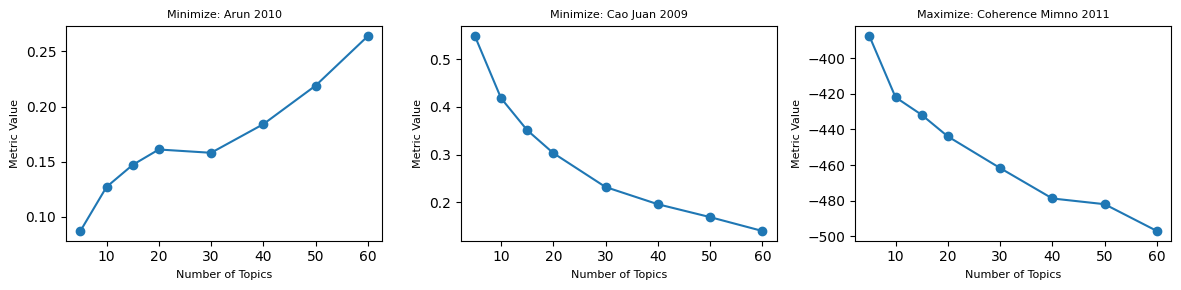

In [66]:
#model parameters
eta_factor = 0.25; alpha_factor = 0.25; k = 30
#claculate parameters
eta = round(0.1/eta_factor,5)
alpha = round(1/(alpha_factor*k), 5)
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 60, eta_value = eta, alpha_value = alpha)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.4, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.11111}, {'n_topics': 10, 'alpha': 0.11111}, {'n_topics': 15, 'alpha': 0.11111}, {'n_topics': 20, 'alpha': 0.11111}, {'n_topics': 30, 'alpha': 0.11111}, {'n_topics': 40, 'alpha': 0.11111}, {'n_topics': 50, 'alpha': 0.11111}, {'n_topics': 60, 'alpha': 0.11111}]
[.] number of results calculated: 8
[.] results by n topic models: [(5, {'arun_2010': 0.094, 'cao_juan_2009': 0.563, 'coherence_mimno_2011': -387.936}), (10, {'arun_2010': 0.138, 'cao_juan_2009': 0.434, 'coherence_mimno_2011': -423.829}), (15, {'arun_2010': 0.174, 'cao_juan_2009': 0.381, 'coherence_mimno_2011': -420.871}), (20, {'arun_2010': 0.157, 'cao_juan_2009': 0.318, 'coherence_mimno_2011': -434.915}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.25, 'coherence_mimno_2011': -453.226}), (40, {'arun_2010': 0.

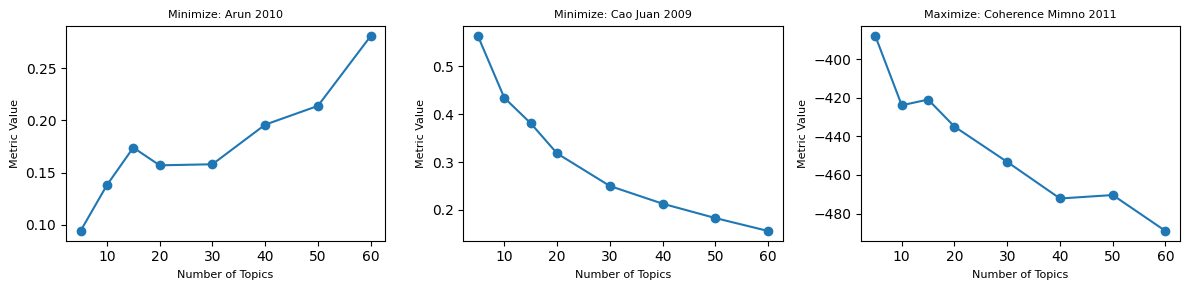

In [67]:
#model parameters
eta_factor = 0.25; alpha_factor = 0.30; k = 30
#claculate parameters
eta = round(0.1/eta_factor,5)
alpha = round(1/(alpha_factor*k), 5)
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 60, eta_value = eta, alpha_value = alpha)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

Base on detailed exploration, the following parameters appear to optimze the charts best:
- Number of Topics = 30
- Eta = 0.1
- Alpha = 1/25

## Building the model
### Import the Corpus

In [82]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_labels_main = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab_main = pickle.load(open(vocab_file_path, 'rb'))

### Create the Model

In [83]:
#model parameters
eta_factor = 1; alpha_factor = 0.25
#eta_factor = 0.25; alpha_factor = 0.35
k = 30
#claculate parameters
eta = round(0.1/eta_factor,5)
alpha = round(1/(alpha_factor*k), 5)
#display parameters for model
print('k:', k,'\teta:', eta,'\talpha:', alpha)

k: 30 	eta: 0.1 	alpha: 0.13333


In [84]:
# set data to use
dtms = {
    'main': dtm_main
}

# and fixed hyperparameters
# Here, alpha represents document-topic density - with a higher alpha, documents
# are made up of more topics, and with lower alpha, documents contain fewer topics.
#Beta represents topic-word density - with a high beta, topics are made up of
#most of the words in the corpus, and with a low beta they consist of few words.
# https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
lda_params = {
    'n_topics': k,
    'eta': eta,
    'n_iter': 1000,
    'random_state': 20191122,  # to make results reproducible
    'alpha': alpha
}

In [85]:
#create the model
models = compute_models_parallel(dtms, constant_parameters=lda_params)

In [86]:
#preview the model
model_main = models['main'][0][1]
print_ldamodel_topic_words(model_main.topic_word_, vocab_main, top_n=3)

topic_1
> #1. comfortable (0.091977)
> #2. foot (0.073879)
> #3. sandal (0.071734)
topic_2
> #1. great (0.258109)
> #2. shoe (0.164267)
> #3. look (0.125428)
topic_3
> #1. color (0.104157)
> #2. black (0.100210)
> #3. shoe (0.078057)
topic_4
> #1. shoe (0.144698)
> #2. foot (0.092833)
> #3. toe (0.076367)
topic_5
> #1. shoe (0.127978)
> #2. nike (0.046457)
> #3. try (0.036709)
topic_6
> #1. find (0.130424)
> #2. shoe (0.089896)
> #3. store (0.064652)
topic_7
> #1. pair (0.125331)
> #2. wear (0.097878)
> #3. buy (0.073359)
topic_8
> #1. fit (0.103988)
> #2. shirt (0.058612)
> #3. short (0.055550)
topic_9
> #1. good (0.175438)
> #2. product (0.121348)
> #3. quality (0.112489)
topic_10
> #1. shoe (0.199118)
> #2. play (0.087198)
> #3. good (0.073728)
topic_11
> #1. run (0.199829)
> #2. shoe (0.184196)
> #3. running (0.048141)
topic_12
> #1. foot (0.132438)
> #2. shoe (0.114045)
> #3. day (0.091974)
topic_13
> #1. shoe (0.122133)
> #2. color (0.116547)
> #3. love (0.106646)
topic_14
> #1. 

### Save Topic Model

In [87]:
#save the model to disk
model_file_path = '%s/main_model.p' % MODEL_DIR

with open(model_file_path, "wb") as modelfile:
    save_ldamodel_to_pickle(modelfile, model_main, vocab_main, doc_labels_main, dtm=dtm_main)

## Classify and Enrich Topic Data

With a final topic model in place, topics can be assigned to documents to automatically cluster the review data by topic. Additional details can be added to the topic model to better filter and focus the dataset.

### Load the Model

In [6]:
#build the paths
corpus_file_path = '%s/corpus.p' % DATA_DIR
model_file_path = '%s/main_model.p' % MODEL_DIR
text_file_path = '%s/corpus_raw_text.p' % DATA_DIR
#load the files
with open(corpus_file_path, "rb") as corpusfile:
    corpus = pickle.load(corpusfile)
with open(text_file_path, "rb") as textfile:
    corpus_raw_text = pickle.load(textfile)
with open(model_file_path, "rb") as modelfile:
    model_info = load_ldamodel_from_pickle(modelfile)

#preview the model info keys
model_info.keys()

dict_keys(['model', 'vocab', 'doc_labels', 'dtm'])

In [7]:
#extract the parts of the model
model_main      = model_info["model"]
vocab_main      = model_info["vocab"]
dtm_main        = model_info["dtm"]
doc_labels_main = model_info["doc_labels"]

### Create Topic Names and Classification

In [8]:
#create a function to create topic labels
def calc_topic_labels(dtm_p, model_p, vocab_p, lamda_p):
  #create the document lengths
  doc_lengths_main = doc_lengths(dtm_p)
  #create the topic label names
  topic_labels_main = generate_topic_labels_from_top_words(
                          model_p.topic_word_,
                          model_p.doc_topic_,
                          doc_lengths_main,
                          vocab_p,
                          lambda_=lamda_p,
                          n_words=4
                      )
  return topic_labels_main

In [9]:
lambda_list = list(range(1,11))
lambda_list = [round(i/10,3) for i in lambda_list]
print(lambda_list)

dict_topic_test = {}

#generate topic labels with a variety of different lambdas and display in a table
for l in lambda_list:
    topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = l)
    key = 'model_lamdda_' + str(int(l*100)).zfill(3)
    dict_topic_test[key] = topic_labels_main

df_dict_topic_test = pd.DataFrame(dict_topic_test)
df_dict_topic_test

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


,model_lamdda_010,model_lamdda_020,model_lamdda_030,model_lamdda_040,model_lamdda_050,model_lamdda_060,model_lamdda_070,model_lamdda_080,model_lamdda_090,model_lamdda_100
0,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_comfortable_foot,1_sandal_comfortable_slide_foot,1_sandal_comfortable_foot_wear,1_comfortable_sandal_foot_wear,1_comfortable_foot_sandal_wear
1,2_great_awesome_look_amazing,2_great_awesome_look_amazing,2_great_look_awesome_feel,2_great_look_awesome_fit,2_great_look_shoe_fit,2_great_look_shoe_fit,2_great_look_shoe_fit,2_great_shoe_look_fit,2_great_shoe_look_fit,2_great_shoe_look_fit
2,3_white_black_red_blue,3_white_black_red_blue,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_color,3_black_white_color_blue,3_black_color_white_blue,3_black_color_white_shoe,3_color_black_shoe_white
3,4_toe_narrow_area_uncomfortable,4_toe_narrow_area_uncomfortable,4_toe_narrow_lace_area,4_toe_narrow_lace_bit,4_toe_narrow_foot_little,4_toe_narrow_foot_shoe,4_toe_shoe_foot_narrow,4_shoe_toe_foot_narrow,4_shoe_foot_toe_narrow,4_shoe_foot_toe_little
4,5_review_bad_help_try,5_review_try_bad_help,5_review_try_bad_help,5_review_try_bad_problem,5_review_try_shoe_bad,5_shoe_review_try_get,5_shoe_try_review_nike,5_shoe_try_nike_review,5_shoe_nike_try_get,5_shoe_nike_try_get
5,6_find_store_amazon_glad,6_find_store_amazon_glad,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_purchase,6_find_store_amazon_purchase,6_find_store_shoe_amazon,6_find_shoe_store_amazon,6_find_shoe_store_pair
6,7_last_replace_month_year,7_last_month_replace_year,7_last_month_pair_year,7_pair_last_year_month,7_pair_year_month_last,7_pair_year_wear_month,7_pair_wear_year_buy,7_pair_wear_year_buy,7_pair_wear_buy_year,7_pair_wear_buy_year
7,8_shirt_short_casual_keep,8_shirt_short_casual_material,8_shirt_short_casual_material,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_fit_shirt_short_nice,8_fit_shirt_short_nice,8_fit_shirt_short_nice
8,9_quality_product_excellent_price,9_quality_product_excellent_good,9_quality_product_excellent_good,9_quality_product_good_excellent,9_product_quality_good_price,9_product_quality_good_price,9_good_product_quality_price,9_good_product_quality_price,9_good_product_quality_nike,9_good_product_quality_nike
9,10_play_tennis_basketball_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_shoe,10_play_basketball_shoe_tennis,10_play_shoe_basketball_tennis,10_shoe_play_basketball_good,10_shoe_play_good_basketball,10_shoe_play_good_basketball


In [10]:
lambda_list = list(range(6,13))
lambda_list = [round(i/20,3) for i in lambda_list]
print(lambda_list)

dict_topic_test = {}

#generate topic labels with a variety of different lambdas and display in a table
for l in lambda_list:
    topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = l)
    key = 'model_lamdda_' + str(int(l*100)).zfill(3)
    dict_topic_test[key] = topic_labels_main

df_dict_topic_test = pd.DataFrame(dict_topic_test)
df_dict_topic_test

[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]


,model_lamdda_030,model_lamdda_035,model_lamdda_040,model_lamdda_045,model_lamdda_050,model_lamdda_055,model_lamdda_060
0,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_clean_soft,1_sandal_slide_comfortable_clean,1_sandal_slide_comfortable_foot
1,2_great_look_awesome_feel,2_great_look_awesome_feel,2_great_look_awesome_fit,2_great_look_awesome_shoe,2_great_look_shoe_fit,2_great_look_shoe_fit,2_great_look_shoe_fit
2,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_red,3_black_white_blue_color
3,4_toe_narrow_lace_area,4_toe_narrow_lace_area,4_toe_narrow_lace_bit,4_toe_narrow_foot_little,4_toe_narrow_foot_little,4_toe_narrow_foot_little,4_toe_narrow_foot_shoe
4,5_review_try_bad_help,5_review_try_bad_problem,5_review_try_bad_problem,5_review_try_bad_shoe,5_review_try_shoe_bad,5_review_shoe_try_bad,5_shoe_review_try_get
5,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_hard,6_find_store_amazon_purchase,6_find_store_amazon_purchase
6,7_last_month_pair_year,7_last_pair_month_year,7_pair_last_year_month,7_pair_last_year_month,7_pair_year_month_last,7_pair_year_month_wear,7_pair_year_wear_month
7,8_shirt_short_casual_material,8_shirt_short_casual_fit,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_shirt_short_fit_nice,8_shirt_short_fit_nice
8,9_quality_product_excellent_good,9_quality_product_good_excellent,9_quality_product_good_excellent,9_product_quality_good_excellent,9_product_quality_good_price,9_product_quality_good_price,9_product_quality_good_price
9,10_play_basketball_tennis_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_soccer,10_play_basketball_tennis_shoe,10_play_basketball_tennis_shoe,10_play_basketball_shoe_tennis


In [11]:
#create the final topics labels for the topic model
topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = 0.4)

#display the list of topic labels
print('created topic labels:')
print(topic_labels_main)

created topic labels:
['1_sandal_slide_clean_soft' '2_great_look_awesome_fit'
 '3_black_white_blue_red' '4_toe_narrow_lace_bit'
 '5_review_try_bad_problem' '6_find_store_amazon_hard'
 '7_pair_last_year_month' '8_shirt_short_fit_nice'
 '9_quality_product_good_excellent' '10_play_basketball_tennis_soccer'
 '11_run_mile_running_runner' '12_day_hour_foot_walk'
 '13_style_different_color_pair' '14_air_max_nike_model'
 '15_sneaker_boot_comfortable_stylish' '16_support_arch_heel_ankle'
 '17_bag_gym_use_hold' '18_gift_christmas_husband_say'
 '19_fast_delivery_arrive_condition' '20_sock_dry_tight_stay'
 '21_compliment_lot_stylish_get' '22_true_size_woman_man'
 '23_size_small_half_large' '24_watch_band_wrist_feature'
 '25_light_weight_training_workout' '26_worth_money_pay_spend'
 '27_look_leather_star_picture' '28_son_old_school_kid'
 '29_color_love_bright_super' '30_return_send_seller_item']


[-368.89312 -322.74507 -360.43086 -372.11214 -386.71346 -348.34829
 -348.75254 -345.26137 -341.87892 -379.43226 -379.79195 -348.0385
 -312.9402  -348.27916 -321.2775  -368.90764 -372.73792 -356.93369
 -387.65693 -350.55304 -339.25639 -368.91942 -319.2408  -406.97673
 -356.98458 -384.25438 -396.92349 -367.6788  -349.01563 -375.29537] 



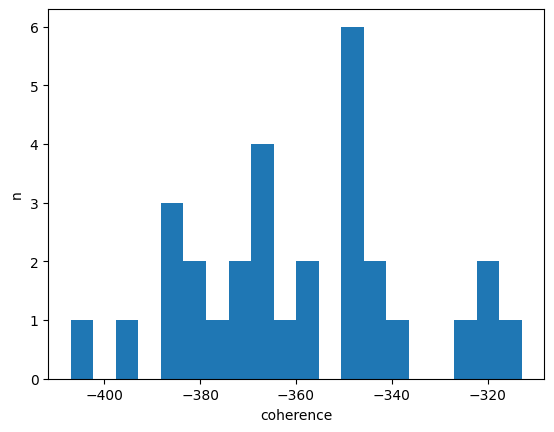


top 10 topics: ['13_style_different_color_pair' '23_size_small_half_large'
 '15_sneaker_boot_comfortable_stylish' '2_great_look_awesome_fit'
 '21_compliment_lot_stylish_get' '9_quality_product_good_excellent'
 '8_shirt_short_fit_nice' '12_day_hour_foot_walk' '14_air_max_nike_model'
 '6_find_store_amazon_hard']

bottom 10 topics: ['24_watch_band_wrist_feature' '27_look_leather_star_picture'
 '19_fast_delivery_arrive_condition' '5_review_try_bad_problem'
 '26_worth_money_pay_spend' '11_run_mile_running_runner'
 '10_play_basketball_tennis_soccer' '30_return_send_seller_item'
 '17_bag_gym_use_hold' '4_toe_narrow_lace_bit']


In [12]:
# Topic Model Coherence
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

# use top 20 words per topic for metric
coh = metric_coherence_mimno_2011(model_main.topic_word_, dtm_main, top_n=10, include_prob=True)
print(coh, '\n')


#display a histogram of the coherence
plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show();

#print the best and worst topics according to this metric
top10_t_indices = np.argsort(coh)[::-1][:10]
bottom10_t_indices = np.argsort(coh)[:10]

print('\ntop 10 topics:', topic_labels_main[top10_t_indices])
print('\nbottom 10 topics:', topic_labels_main[bottom10_t_indices])

### Classify the Documents

In [13]:
#classify each document with the label
doc_topic_main = model_main.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic_main,
                                                  doc_labels_main,
                                                  top_n=3,
                                                  topic_labels=topic_labels_main)
#preview the document classifications
documentclassifications.head()

,rank_1,rank_2,rank_3
document,,,
0,3_black_white_blue_red (0.2849),30_return_send_seller_item (0.1939),28_son_old_school_kid (0.103)
1,24_watch_band_wrist_feature (0.1939),20_sock_dry_tight_stay (0.1939),29_color_love_bright_super (0.1939)
2,30_return_send_seller_item (0.4278),24_watch_band_wrist_feature (0.1778),8_shirt_short_fit_nice (0.09444)
3,8_shirt_short_fit_nice (0.1889),9_quality_product_good_excellent (0.1889),30_return_send_seller_item (0.02222)
4,21_compliment_lot_stylish_get (0.4278),24_watch_band_wrist_feature (0.1778),9_quality_product_good_excellent (0.09444)


In [14]:
#add details from the dicument to label table
documentclassifications['rank_1_topic'] = [i.split(' ')[0]for i in documentclassifications['rank_1']]
documentclassifications['rank_1_prob'] = [float(i.split(' ')[1][1:-1]) for i in documentclassifications['rank_1']]
documentclassifications['rank_2_topic'] = [i.split(' ')[0] for i in documentclassifications['rank_2']]
documentclassifications['rank_2_prob'] = [float(i.split(' ')[1][1:-1]) for i in documentclassifications['rank_2']]
documentclassifications['rank_3_topic'] = [i.split(' ')[0] for i in documentclassifications['rank_3']]
documentclassifications['rank_3_prob'] = [float(i.split(' ')[1][1:-1]) for i in documentclassifications['rank_3']]
#drop the combined columns
documentclassifications = documentclassifications.drop(columns = ['rank_1','rank_2','rank_3'])
#preview the document classifications
documentclassifications.head()

,rank_1_topic,rank_1_prob,rank_2_topic,rank_2_prob,rank_3_topic,rank_3_prob
document,,,,,,
0,3_black_white_blue_red,0.2849,30_return_send_seller_item,0.1939,28_son_old_school_kid,0.10300
1,24_watch_band_wrist_feature,0.1939,20_sock_dry_tight_stay,0.1939,29_color_love_bright_super,0.19390
2,30_return_send_seller_item,0.4278,24_watch_band_wrist_feature,0.1778,8_shirt_short_fit_nice,0.09444
3,8_shirt_short_fit_nice,0.1889,9_quality_product_good_excellent,0.1889,30_return_send_seller_item,0.02222
4,21_compliment_lot_stylish_get,0.4278,24_watch_band_wrist_feature,0.1778,9_quality_product_good_excellent,0.09444


C:\Users\silve\AppData\Local\Temp\ipykernel_30060\616221435.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(documentclassifications['rank_1_prob'])
C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

<Axes: xlabel='rank_1_prob', ylabel='Density'>

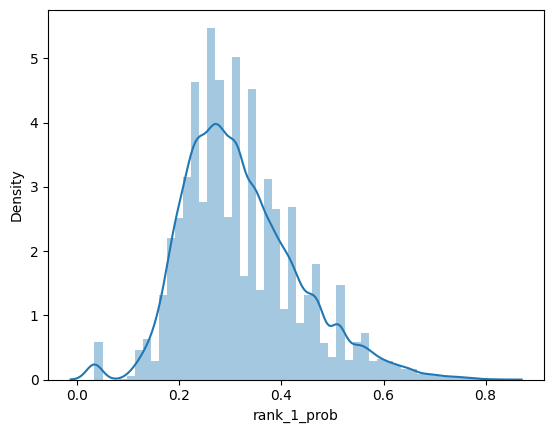

In [15]:
#plot the distribution of rank 1 topics
sns.distplot(documentclassifications['rank_1_prob'])

C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\silve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) 

<Axes: ylabel='Percent'>

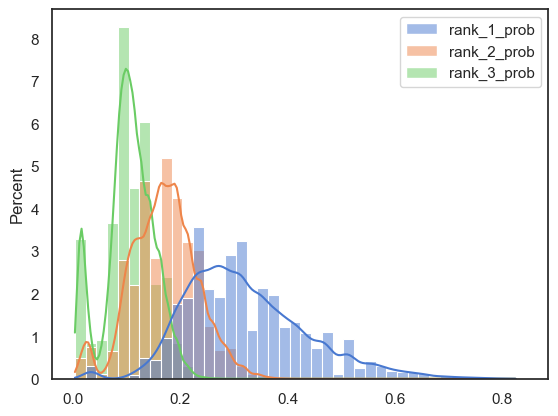

In [16]:
#plot the probability distribution for topics (rank 1 - rank 3)
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.histplot(documentclassifications[['rank_1_prob','rank_2_prob','rank_3_prob']],
             kde=True,
             stat="percent",
             binwidth = 0.02)

### Enrich Data with Review Info

In [17]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [18]:
#extract fields from all review details
reviews = []
asin = []
overall_rating = []
reviewer_id = []

#extract review details to add to the tagged documents
for a_review in json_file:
    the_review = json_file[a_review]
    reviews.append(the_review["reviewText"])
    asin.append(the_review["asin"])
    overall_rating.append(the_review["overall"])
    reviewer_id.append(the_review["reviewerID"])

In [19]:
#add details from the dicument to label table
documentclassifications['text'] = reviews
documentclassifications['asin'] = asin
documentclassifications['overall_rating'] = overall_rating
documentclassifications['reviewer_id'] = reviewer_id
#preview the document classifications
documentclassifications.head()

,rank_1_topic,rank_1_prob,rank_2_topic,rank_2_prob,rank_3_topic,rank_3_prob,text,asin,overall_rating,reviewer_id
document,,,,,,,,,,
0,3_black_white_blue_red,0.2849,30_return_send_seller_item,0.1939,28_son_old_school_kid,0.10300,the colour i received is not blue as shown but...,B0000V9K32,3.0,ACT5DY536GISV
1,24_watch_band_wrist_feature,0.1939,20_sock_dry_tight_stay,0.1939,29_color_love_bright_super,0.19390,Very cute and is really practical. Fits better...,B0000V9K32,5.0,A3BVWMS9I8OH8U
2,30_return_send_seller_item,0.4278,24_watch_band_wrist_feature,0.1778,8_shirt_short_fit_nice,0.09444,The watch was exactly what i ordered and I got...,B0000V9K3W,4.0,A5RZS69KSJH00
3,8_shirt_short_fit_nice,0.1889,9_quality_product_good_excellent,0.1889,30_return_send_seller_item,0.02222,"This product came promptly and as described, p...",B0000V9K46,5.0,A3F8O512N9UNVM
4,21_compliment_lot_stylish_get,0.4278,24_watch_band_wrist_feature,0.1778,9_quality_product_good_excellent,0.09444,Why isn't Nike making these anymore? I love t...,B0000V9KNM,4.0,A2EAKTCKFRF7A4


### Enrich the Data with Product Info

In [20]:
#this assigns the filename we're trying to load
allnikeproducts_file_path = '%s/allnikeproducts.p' % DATA_DIR
allnikeproducts = pickle.load(open(allnikeproducts_file_path, 'rb'))

allnikeproducts['B0000V9K32']

{'asin': 'B0000V9K32',
 'salesRank': {'Watches': 67039},
 'imUrl': 'http://ecx.images-amazon.com/images/I/412N3YVIbhL._SY300_.jpg',
 'categories': [['Clothing, Shoes & Jewelry', 'N', 'Nike'],
  ['Clothing, Shoes & Jewelry', 'Nike Watches'],
  ['Clothing, Shoes & Jewelry', 'Women', 'Watches', 'Wrist Watches']],
 'title': 'Nike - WT0008402 (Size: women)'}

In [21]:
nike_asin_list = list(documentclassifications['asin'])
print(nike_asin_list[1:5])

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46', 'B0000V9KNM']


In [22]:
allnikeproducts['B0000V9K32']['salesRank']

{'Watches': 67039}

In [23]:
allnikeproducts[nike_asin_list[0]]['salesRank'].keys()

dict_keys(['Watches'])

In [24]:
sale_category = []
sale_rank = []
title = []

#extract out product details to add to the tagged documents
for asin in nike_asin_list:
    #print(asin)
    the_product = allnikeproducts[asin]
    #print(the_product)
    if the_product.get("salesRank"):
      sale_category.append(list(allnikeproducts[asin]['salesRank'].keys())[0])
      sale_rank.append(list(allnikeproducts[asin]['salesRank'].values())[0])
    else:
      sale_category.append('Unknown')
      sale_rank.append(None)
    title.append(the_product['title'])

#add details from the dicument to label table
documentclassifications['sale_category'] = sale_category
documentclassifications['sale_rank'] = sale_rank
documentclassifications['title'] = title
#preview the document classifications
documentclassifications.head()

,rank_1_topic,rank_1_prob,rank_2_topic,rank_2_prob,rank_3_topic,rank_3_prob,text,asin,overall_rating,reviewer_id,sale_category,sale_rank,title
document,,,,,,,,,,,,,
0,3_black_white_blue_red,0.2849,30_return_send_seller_item,0.1939,28_son_old_school_kid,0.10300,the colour i received is not blue as shown but...,B0000V9K32,3.0,ACT5DY536GISV,Watches,67039.0,Nike - WT0008402 (Size: women)
1,24_watch_band_wrist_feature,0.1939,20_sock_dry_tight_stay,0.1939,29_color_love_bright_super,0.19390,Very cute and is really practical. Fits better...,B0000V9K32,5.0,A3BVWMS9I8OH8U,Watches,67039.0,Nike - WT0008402 (Size: women)
2,30_return_send_seller_item,0.4278,24_watch_band_wrist_feature,0.1778,8_shirt_short_fit_nice,0.09444,The watch was exactly what i ordered and I got...,B0000V9K3W,4.0,A5RZS69KSJH00,Watches,102054.0,Nike Presto Cee Digital Large Ladies - Light B...
3,8_shirt_short_fit_nice,0.1889,9_quality_product_good_excellent,0.1889,30_return_send_seller_item,0.02222,"This product came promptly and as described, p...",B0000V9K46,5.0,A3F8O512N9UNVM,Watches,116131.0,Nike - WT0003701 (Size: women large)
4,21_compliment_lot_stylish_get,0.4278,24_watch_band_wrist_feature,0.1778,9_quality_product_good_excellent,0.09444,Why isn't Nike making these anymore? I love t...,B0000V9KNM,4.0,A2EAKTCKFRF7A4,Watches,105485.0,Nike Presto Collection Women's Sport Watch Whi...


### Enrich Data with Sentiment

In [25]:
#create a function to get the sentiment of a list of text
def get_sentiment_texts(texts):
    """Implement this function which should take a list of texts
    and returns 2 lists with the sentiment polarity

    See the TextBlob documentation for how to evaluate sentiment. For our
    purposes here, negative sentiment is a sentiment with polarity < 0.0.
    """
    texts_length = len(texts)
    sentiments = [None] * texts_length
    results = []
    print('processing sentiments for', texts_length, 'texts:')
    for t, i in zip(texts, range(len(texts))):
      text = TextBlob(t)
      sentiments[i] = text.sentiment.polarity

    return sentiments

In [26]:
#add details from the dicument to label table
documentclassifications['sentiment'] = get_sentiment_texts(list(documentclassifications['text']))
#add flag for sentiment
documentclassifications['positive_sentiment'] = [i >= 0 for i in documentclassifications['sentiment']]
documentclassifications['negative_sentiment'] = [i < 0 for i in documentclassifications['sentiment']]
#add overal rating categories
documentclassifications['overall_rating_low'] = [i <= 2 for i in documentclassifications['overall_rating']]
documentclassifications['overall_rating_high'] = [i >= 4 for i in documentclassifications['overall_rating']]
#preview the document classifications
documentclassifications.head(3)

processing sentiments for 21570 texts:


,rank_1_topic,rank_1_prob,rank_2_topic,rank_2_prob,rank_3_topic,rank_3_prob,text,asin,overall_rating,reviewer_id,sale_category,sale_rank,title,sentiment,positive_sentiment,negative_sentiment,overall_rating_low,overall_rating_high
document,,,,,,,,,,,,,,,,,,
0,3_black_white_blue_red,0.2849,30_return_send_seller_item,0.1939,28_son_old_school_kid,0.10300,the colour i received is not blue as shown but...,B0000V9K32,3.0,ACT5DY536GISV,Watches,67039.0,Nike - WT0008402 (Size: women),0.066667,True,False,False,False
1,24_watch_band_wrist_feature,0.1939,20_sock_dry_tight_stay,0.1939,29_color_love_bright_super,0.19390,Very cute and is really practical. Fits better...,B0000V9K32,5.0,A3BVWMS9I8OH8U,Watches,67039.0,Nike - WT0008402 (Size: women),0.395000,True,False,False,True
2,30_return_send_seller_item,0.4278,24_watch_band_wrist_feature,0.1778,8_shirt_short_fit_nice,0.09444,The watch was exactly what i ordered and I got...,B0000V9K3W,4.0,A5RZS69KSJH00,Watches,102054.0,Nike Presto Cee Digital Large Ladies - Light B...,0.002500,True,False,False,True


### Preview Samples from Topic Labels

In [27]:
#preview the topic labels for a sample record
k = 901
documentclassifications.loc[k]

rank_1_topic                                  30_return_send_seller_item
rank_1_prob                                                       0.3167
rank_2_topic                           19_fast_delivery_arrive_condition
rank_2_prob                                                       0.2854
rank_3_topic                                 24_watch_band_wrist_feature
rank_3_prob                                                       0.1292
text                   Watch is great! I actually have the same one w...
asin                                                          B000E8J5XG
overall_rating                                                       5.0
reviewer_id                                               A1QZ4W6FVUUIJ7
sale_category                                                    Watches
sale_rank                                                       105290.0
title                  Nike Men's WA0038-001 Oregon Series Square Dig...
sentiment                                          

In [28]:
#preview the full text for the sample record
documentclassifications.loc[k]['text']

'Watch is great! I actually have the same one with a Brown band instead of a black. I get compliments on it all the time and it is a very cool time piece.The only issue I had was that I ordered EXPEDITED shipping and paid 17 dollars to get it to me in 1-3 buisness days. I wanted to have it for New Years Eve.It didnt show up until about 10 days after the date of purchase. However I was able to email the company and they responded promptly and then were able to refund my shipping costs.All in all it was a very good purchase, the problem with the shipping put a damper on things, but the refund of the shipping was great customer service.'

### Export the Topic Labels to Excel

In [29]:
#export the topic classification data to excel
topic_excel_path = '%s/topics.documentclassification.xlsx' % DATA_DIR
documentclassifications.to_excel(topic_excel_path)

## Model Evaluation
### Visualize the Topics

In [30]:
#create parameters for ldavis
ldavis_params = parameters_for_ldavis(model_main.topic_word_,
                                      model_main.doc_topic_,
                                      dtm_main,
                                      vocab_main)

In [32]:
#plot the distance map
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)


In [33]:
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

### Visualize Segmentations
Overview of Sales Category

<Axes: xlabel='count', ylabel='sale_category'>

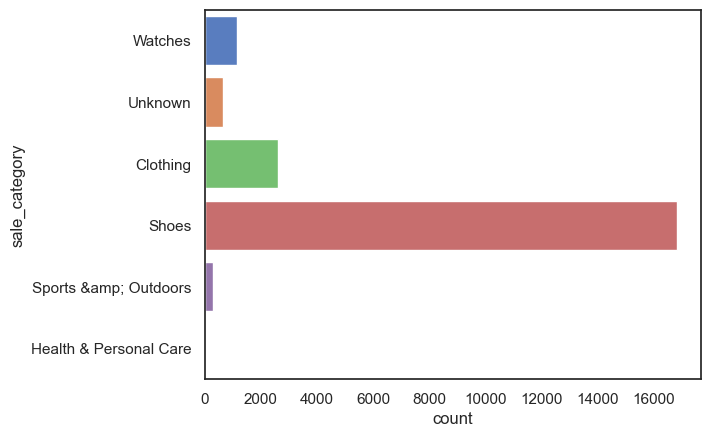

In [131]:
#plot the distribution of reviews across the different sales categories
sns.countplot(data=documentclassifications, y="sale_category")

Top 5 Products Most Negative Sentiment

In [132]:
#create a table of the top negative sentiment products
df_asin = documentclassifications[['asin','title', 'sentiment']]
df_asin = df_asin[df_asin['sentiment'] < 0]
df_asin = df_asin.groupby(['asin','title']).agg(['mean','count']).reset_index()
df_asin.columns = ['_'.join(col) for col in df_asin.columns]
df_asin = df_asin.rename(columns={'asin_': 'asin', 'title_': 'title', 'sentiment_count': 'count'})
df_asin = df_asin[df_asin['count'] >= 10]
df_asin = df_asin.sort_values(by=['count'], ascending=False)
df_asin = df_asin.head(5)
df_asin

,asin,title,sentiment_mean,count
691,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size...,-0.151496,62
103,B000V4YZ1K,Nike Men's Benassi Swoosh Slide Sandal,-0.146498,57
355,B004IM1GHW,Nike Air Monarch IV Men's Cross Training Shoes,-0.111665,55
1013,B00CHSCDM6,Nike 2014 Grillroom Golf Shoes Men's Anthracit...,-0.139225,16
7,B0007RADZ8,Nike Men's Revolution 2 Running Shoe,-0.118487,15


Top 5 Most Negative Sentiment

In [136]:
#adjust pandas settings to display all text
pd.set_option('display.max_colwidth', None)
#focus on a specific product and display negative review text for the product
df_prod_dtl = documentclassifications[documentclassifications['asin'] == 'B007FXKMLW']
df_prod_dtl = df_prod_dtl[df_prod_dtl['sentiment'] < 0]
df_prod_dtl = df_prod_dtl[df_prod_dtl['overall_rating'] < 3]
df_prod_dtl = df_prod_dtl[df_prod_dtl['rank_1_prob'] >= 0.3]
df_prod_dtl = df_prod_dtl.sort_values(by=['rank_1_topic', 'sentiment'], ascending=True).reset_index()
df_prod_dtl = df_prod_dtl[['asin','title', 'sale_category', 'overall_rating', 'sentiment',
                           'rank_1_topic', 'rank_1_prob', 'text']]
df_prod_dtl.head(5)

,asin,title,sale_category,overall_rating,sentiment,rank_1_topic,rank_1_prob,text
0,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size: 10 M US MENS,Shoes,1.0,-0.025000,22_true_size_woman_man,0.3567,"With the shoes playing host to part of the universe, I thought they would be one size fits all and that they would expand to my size. I was wrong. What's more is they have not been designed for space travel, I tried them out in the British winter which has a very similar climate to space, the temperature must have dropped to like 11 degrees Celsius before severe frostbite took both of my feet. To add insult to injury the shoes were stolen when my feet detached, you would think with the price some kind of alarm of tracking device would have been fitted.Very disappointed."
1,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size: 10 M US MENS,Shoes,2.0,-0.193333,26_worth_money_pay_spend,0.4567,These shoes are a bit over my price range so I thought I would see if I could buy 1 for half the price. I thought if I bought one for my husband (they are just his size) then he would be at least halfway cool. Unfortunately buying just one wasn't an option. It's really not fair to people on a budget that these shoes must come in a pair.
2,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size: 10 M US MENS,Shoes,1.0,-0.187500,26_worth_money_pay_spend,0.3208,"I had to stand on the corner and turn tricks for a month to save up for these shoes and then they don't have women's sizes! Damn! Now I'll have to use that money to buy food and pay the rent. Well that's no fun. What am I going to wear to make everyone say ooh, ahh and be all jealous and everything. Sexist creeps!"
3,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size: 10 M US MENS,Shoes,1.0,-0.111111,26_worth_money_pay_spend,0.4593,"Seriously, they look like crap. You people are nuts for buying them. Y'all deserve to starve for spending money on these rather than feeding your families. Lol"
4,B007FXKMLW,NIKE AIR FOAMPOSITE ONE NRG Style# 521286 Size: 10 M US MENS,Shoes,2.0,-0.054287,26_worth_money_pay_spend,0.4519,"Appears to me THAT the people with, I guess with educations, and well paying jobs, get the shoes. However, I feel ""dat"" the people who have to use words like ""dat"", and have to steal girls & friend's money, not pay child support or loose anal virginity then they should take a better look in the mirror, get priorities in order and with words like ""dat"" an EDUCATION would be helpful (at least a dictionary)!!!"


### Sentiment vs. Category Across Sale Categories

[Text(0.5, 1.0, 'Not Shoes & Watched Sales Category')]

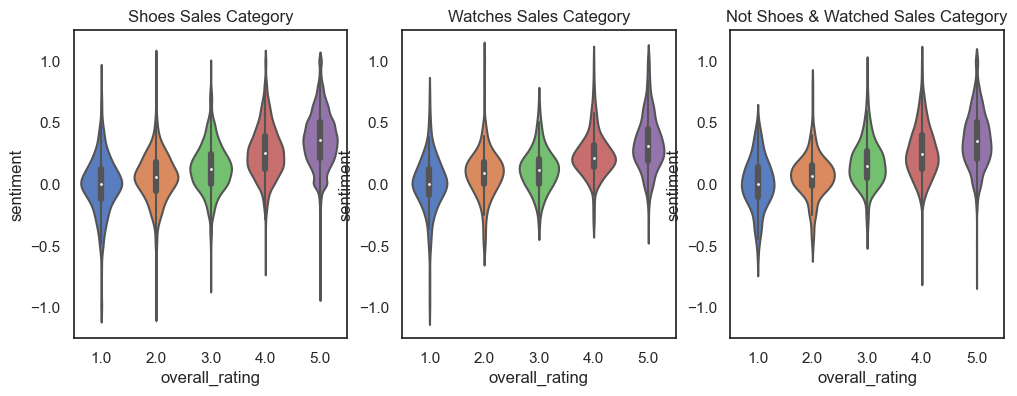

In [137]:
#segment data acrtoss 3 categories of the sales category field
dc_shoes = documentclassifications[documentclassifications['sale_category'] == 'Shoes']
dc_watches = documentclassifications[documentclassifications['sale_category'] == 'Watches']
dc_other = documentclassifications[(documentclassifications['sale_category'] != 'Shoes')
                                   & (documentclassifications['sale_category'] != 'Watches')]
#display plots for the distribution of sentiment across each overall rating level
f, axes = plt.subplots(1,3, figsize=(12, 4))
min_lim = -1.25; max_lim = 1.25
axes[0].set(ylim=(min_lim, max_lim)); axes[1].set(ylim=(min_lim, max_lim)); axes[2].set(ylim=(min_lim, max_lim))
sns.violinplot(data=dc_shoes, x="overall_rating", y="sentiment", ax=axes[0]).set(title='Shoes Sales Category')
sns.violinplot(data=dc_watches, x="overall_rating", y="sentiment", ax=axes[1]).set(title='Watches Sales Category')
sns.violinplot(data=dc_other, x="overall_rating", y="sentiment", ax=axes[2]).set(title='Not Shoes & Watched Sales Category')

### Heatmap of Topics vs. Categories

In [138]:
#summarize the tagged documents into their rank_1 topics with aggregate metrics
df_sum_cats = documentclassifications[['sale_category','rank_1_topic', 'sentiment']]
df_sum_cats = df_sum_cats.groupby(['sale_category','rank_1_topic']).agg(['min','mean','max','count']).reset_index()
df_sum_cats.columns = ['_'.join(col) for col in df_sum_cats.columns]
df_sum_cats = df_sum_cats.rename(columns={'sale_category_': 'sale_category', 'rank_1_topic_': 'rank_1_topic', 'sentiment_count': 'count'})
df_sum_cats['sale_category_count'] = df_sum_cats.groupby('sale_category')['count'].transform('sum')
df_sum_cats['pct_of_sales_category'] = df_sum_cats['count'] / df_sum_cats['sale_category_count']
df_sum_cats.head(3)

,sale_category,rank_1_topic,sentiment_min,sentiment_mean,sentiment_max,count,sale_category_count,pct_of_sales_category
0,Clothing,10_play_basketball_tennis_soccer,-0.500000,0.316213,1.00,54,2616,0.020642
1,Clothing,11_run_mile_running_runner,-0.183105,0.282678,0.69,29,2616,0.011086
2,Clothing,12_day_hour_foot_walk,-0.200000,0.299493,1.00,31,2616,0.011850


In [139]:
#summarize the columns in the table
df_sum_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_category          154 non-null    object 
 1   rank_1_topic           154 non-null    object 
 2   sentiment_min          154 non-null    float64
 3   sentiment_mean         154 non-null    float64
 4   sentiment_max          154 non-null    float64
 5   count                  154 non-null    int64  
 6   sale_category_count    154 non-null    int64  
 7   pct_of_sales_category  154 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 9.8+ KB


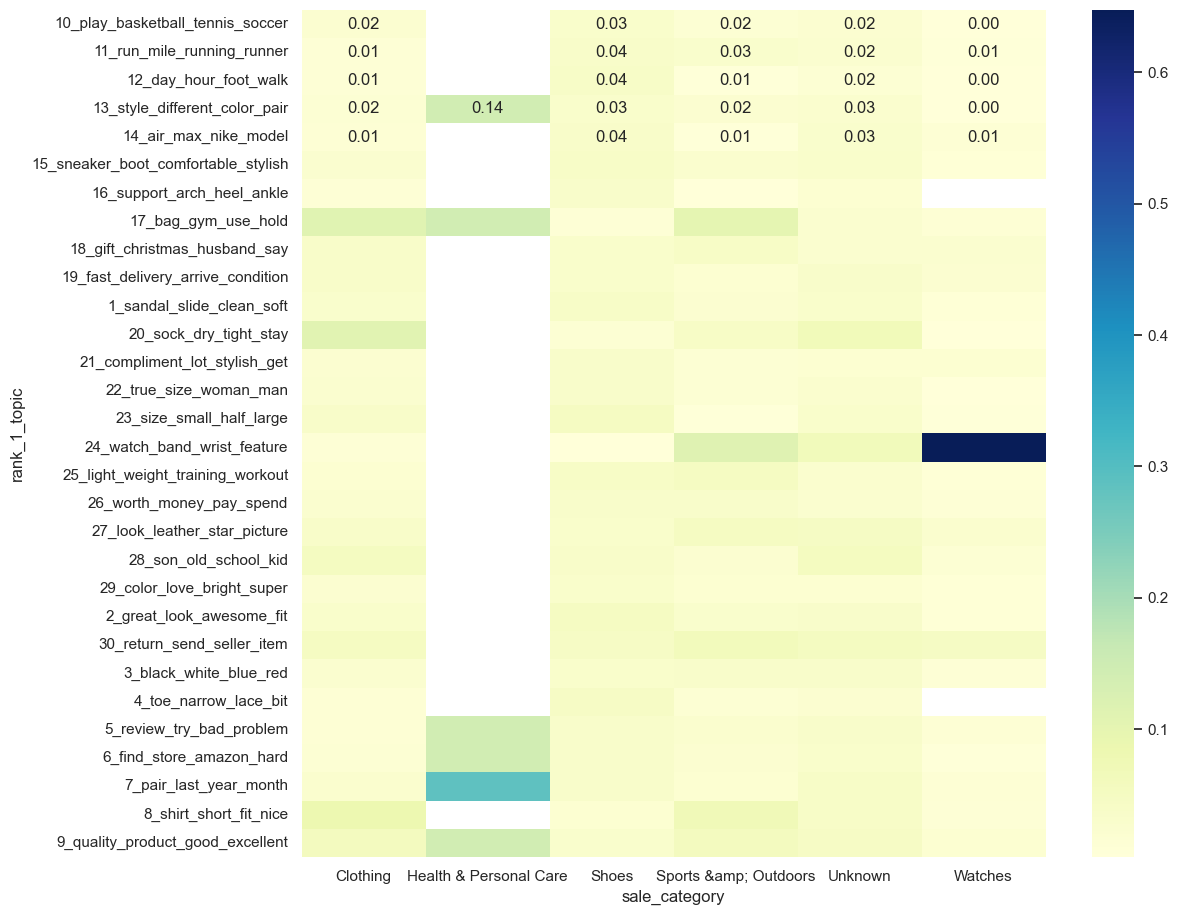

In [143]:
df_heat = df_sum_cats[['sale_category','rank_1_topic', 'pct_of_sales_category']]
f, axes = plt.subplots(1,1, figsize=(12, 11))
ax = sns.heatmap(df_heat.pivot(index="rank_1_topic", columns="sale_category", values="pct_of_sales_category"), 
                 annot=True, 
                 fmt=".2f", 
                 cmap="YlGnBu")

### Explore Extended List of Words for Topics

In [144]:
#create the top topic words for each topic in the model and add to table
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(model_main.topic_word_,
                                          vocab_main,
                                          row_labels=topic_labels_main,
                                          top_n=15,
                                          val_fmt = '{lbl}').reset_index()
top_topic_word['rank_1'] = [i.split(' ')[0] for i in top_topic_word['rank_1']]

top_topic_word[top_topic_word['topic'] == '7_pair_last_year_month']

,topic,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,rank_11,rank_12,rank_13,rank_14,rank_15
6,7_pair_last_year_month,pair,wear,buy,year,shoe,nike,month,new,time,day,comfortable,last,old,week,break


In [145]:
#sample of the top topic owrds dataframe
top_topic_word[top_topic_word['topic'] == '7_pair_last_year_month'].values.tolist()[0][1:]

['pair',
 'wear',
 'buy',
 'year',
 'shoe',
 'nike',
 'month',
 'new',
 'time',
 'day',
 'comfortable',
 'last',
 'old',
 'week',
 'break']

### Negative Sentiment Proportion

In [146]:
# Determine Percent Negative for Rank 1 Topics
df_sent_count = documentclassifications[['rank_1_topic', 'sentiment', 'positive_sentiment', 'negative_sentiment']]
df_sent_count = df_sent_count.drop(columns = ['sentiment'])
df_sent_count = df_sent_count.groupby(['rank_1_topic']).agg(['sum', 'count']).reset_index()
df_sent_count.columns = ['_'.join(col) for col in df_sent_count.columns]
df_sent_count = df_sent_count.drop(columns = ['positive_sentiment_count'])
df_sent_count = df_sent_count.rename(columns={'rank_1_topic_': 'rank_1_topic',
                                          'negative_sentiment_count': 'total_count',
                                          'positive_sentiment_sum': 'positive_sentiment',
                                          'negative_sentiment_sum': 'negative_sentiment'})
df_sent_count['pct_neg_sentiment'] = df_sent_count['negative_sentiment'] / df_sent_count['total_count']
df_sent_count['pct_neg_sentiment'] = [round(i,3) for i in df_sent_count['pct_neg_sentiment']]
df_sent_count = df_sent_count.sort_values(by=['pct_neg_sentiment'], ascending=False)
df_sent_count.head(3)

,rank_1_topic,positive_sentiment,negative_sentiment,total_count,pct_neg_sentiment
14,23_size_small_half_large,756,221,977,0.226
22,30_return_send_seller_item,782,210,992,0.212
24,4_toe_narrow_lace_bit,643,172,815,0.211


In [147]:
# Mean Rating for Rank 1
df_or = documentclassifications[['rank_1_topic', 'overall_rating']]
df_or = df_or.groupby(['rank_1_topic']).agg(['mean', 'count']).reset_index()
df_or.columns = ['_'.join(col) for col in df_or.columns]
df_or = df_or.rename(columns={'rank_1_topic_': 'rank_1_topic',
                              'overall_rating_count': 'total_count'})
df_or['overall_rating_mean'] = [round(i,2) for i in df_or['overall_rating_mean']]
df_or = df_or.sort_values(by=['overall_rating_mean'], ascending=True)
df_or.head(3)

,rank_1_topic,overall_rating_mean,total_count
22,30_return_send_seller_item,3.61,992
24,4_toe_narrow_lace_bit,3.64,815
15,24_watch_band_wrist_feature,3.68,933


In [148]:
# Count Low and High Overall Rating Rating for Rank 1
df_or_cat = documentclassifications[['rank_1_topic', 'overall_rating_low', 'overall_rating_high']]
df_or_cat = df_or_cat.groupby(['rank_1_topic']).agg(['sum']).reset_index()
df_or_cat.columns = ['_'.join(col) for col in df_or_cat.columns]
df_or_cat = df_or_cat.rename(columns={'rank_1_topic_': 'rank_1_topic',
                              'overall_rating_low_sum': 'overall_rating_low',
                              'overall_rating_high_sum': 'overall_rating_high',})
df_or_cat['pct_low_rating'] = df_or_cat['overall_rating_low'] / (df_or_cat['overall_rating_low'] + df_or_cat['overall_rating_high'])
df_or_cat['pct_low_rating'] = [round(i,3) for i in df_or_cat['pct_low_rating']]
df_or_cat = df_or_cat.sort_values(by=['pct_low_rating'], ascending=False)
df_or_cat.head(3)

,rank_1_topic,overall_rating_low,overall_rating_high,pct_low_rating
22,30_return_send_seller_item,294,618,0.322
15,24_watch_band_wrist_feature,210,596,0.261
25,5_review_try_bad_problem,155,450,0.256


In [149]:
# calculate the top topic words and create the base of the topic summary metric table
df_sum_rank = documentclassifications[['rank_1_topic', 'sentiment']]
df_sum_rank = df_sum_rank.groupby(['rank_1_topic']).agg(['min','mean','max','count']).reset_index()
df_sum_rank.columns = ['_'.join(col) for col in df_sum_rank.columns]
df_sum_rank = df_sum_rank.rename(columns={'rank_1_topic_': 'rank_1_topic', 'sentiment_count': 'count'})
df_sum_rank['total_count'] = df_sum_rank['count'].sum()
df_sum_rank['pct_of_total'] = df_sum_rank['count'] / df_sum_rank['total_count']
#round the numeric columns in the table
df_sum_rank['pct_of_total'] = [round(i,3) for i in df_sum_rank['pct_of_total']]
df_sum_rank['sentiment_min'] = [round(i,3) for i in df_sum_rank['sentiment_min']]
df_sum_rank['sentiment_mean'] = [round(i,3) for i in df_sum_rank['sentiment_mean']]
df_sum_rank['sentiment_max'] = [round(i,3) for i in df_sum_rank['sentiment_max']]
#sort the table
df_sum_rank = df_sum_rank.sort_values(by=['sentiment_mean'], ascending=True)
#add list of topic words
df_sum_rank['top_topic_words'] = [top_topic_word[top_topic_word['topic'] == i].values.tolist()[0][1:] for i in df_sum_rank['rank_1_topic']]
#preview data
df_sum_rank.head(3)

,rank_1_topic,sentiment_min,sentiment_mean,sentiment_max,count,total_count,pct_of_total,top_topic_words
14,23_size_small_half_large,-0.50,0.120,1.0,977,21570,0.045,"[size, small, order, run, big, large, half, little, shoe, wear, bit, tight, return, fit, get]"
24,4_toe_narrow_lace_bit,-0.65,0.143,1.0,815,21570,0.038,"[shoe, foot, toe, little, narrow, bit, fit, tight, lace, feel, box, wear, like, break, area]"
22,30_return_send_seller_item,-1.00,0.145,1.0,992,21570,0.046,"[order, return, receive, send, item, amazon, seller, time, product, shoe, shipping, want, day, size, arrive]"


In [150]:
#join the different metric tables into a single table
df_sum_rank = df_sum_rank.merge(df_or_cat[['pct_low_rating', 'rank_1_topic']], on = 'rank_1_topic', how = 'left')
df_sum_rank = df_sum_rank.merge(df_or[['overall_rating_mean', 'rank_1_topic']], on = 'rank_1_topic', how = 'left')
df_sum_rank = df_sum_rank.merge(df_sent_count[['pct_neg_sentiment', 'rank_1_topic']], on = 'rank_1_topic', how = 'left')
df_sum_rank = df_sum_rank.drop(columns=['sentiment_min','sentiment_max','total_count'])
df_sum_rank.head(3)

,rank_1_topic,sentiment_mean,count,pct_of_total,top_topic_words,pct_low_rating,overall_rating_mean,pct_neg_sentiment
0,23_size_small_half_large,0.120,977,0.045,"[size, small, order, run, big, large, half, little, shoe, wear, bit, tight, return, fit, get]",0.223,3.73,0.226
1,4_toe_narrow_lace_bit,0.143,815,0.038,"[shoe, foot, toe, little, narrow, bit, fit, tight, lace, feel, box, wear, like, break, area]",0.243,3.64,0.211
2,30_return_send_seller_item,0.145,992,0.046,"[order, return, receive, send, item, amazon, seller, time, product, shoe, shipping, want, day, size, arrive]",0.322,3.61,0.212


In [151]:
#normalize the sentiment metrics and compute a combined score
df_sum_rank['pct_neg_sentiment_norm'] = MinMaxScaler().fit_transform(np.array(df_sum_rank['pct_neg_sentiment']).reshape(-1,1))
df_sum_rank['overall_rating_mean_norm'] = MinMaxScaler().fit_transform(np.array(df_sum_rank['overall_rating_mean']).reshape(-1,1))
df_sum_rank['pct_low_rating_norm'] = MinMaxScaler().fit_transform(np.array(df_sum_rank['pct_low_rating']).reshape(-1,1))
df_sum_rank['sentiment_mean_norm'] = 1 - MinMaxScaler().fit_transform(np.array(df_sum_rank['sentiment_mean']).reshape(-1,1))
df_sum_rank['neg_view_score'] = (df_sum_rank['pct_neg_sentiment_norm'] + df_sum_rank['overall_rating_mean_norm'] + df_sum_rank['pct_low_rating_norm'] + df_sum_rank['sentiment_mean_norm']) / 4
df_sum_rank['neg_view_score'] = [round(i,3) for i in df_sum_rank['neg_view_score']]
df_sum_rank['neg_view_score'] = MinMaxScaler().fit_transform(np.array(df_sum_rank['neg_view_score']).reshape(-1,1))
df_sum_rank = df_sum_rank.sort_values(by=['neg_view_score'], ascending=False).reset_index()
bottom_5_topics = df_sum_rank['rank_1_topic'].head(5)
top_5_topics = df_sum_rank['rank_1_topic'].tail(5)
df_sum_rank.head(1)

,index,rank_1_topic,sentiment_mean,count,pct_of_total,top_topic_words,pct_low_rating,overall_rating_mean,pct_neg_sentiment,pct_neg_sentiment_norm,overall_rating_mean_norm,pct_low_rating_norm,sentiment_mean_norm,neg_view_score
0,2,30_return_send_seller_item,0.145,992,0.046,"[order, return, receive, send, item, amazon, seller, time, product, shoe, shipping, want, day, size, arrive]",0.322,3.61,0.212,0.934272,0.0,1.0,0.929178,1.0


<Axes: xlabel='neg_view_score', ylabel='Percent'>

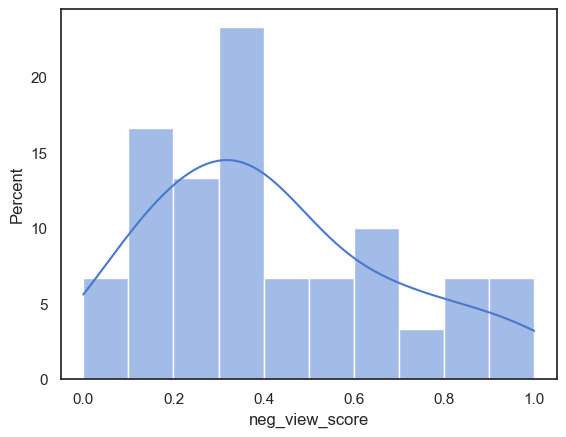

In [152]:
# plot the distribution of topic tags by negative review score metric
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.histplot(df_sum_rank['neg_view_score'],
             kde=True,
             stat="percent",
             binwidth = 0.1)

In [153]:
#displaty topic world list for an example topic in the model
print(df_sum_rank[df_sum_rank['rank_1_topic'] == '2_great_look_awesome_fit']['top_topic_words'])

29    [great, shoe, look, fit, feel, comfortable, good, price, recommend, buy, awesome, love, expect, amazing, running]
Name: top_topic_words, dtype: object


## Investigate: Shoe Sizing
### Select a Problem

Based on the sorted list, we can view the bottom 5 topics for Nike. For some topics (like 30_return_send_seller_item and 5_review_try_bad_problem) there is little Nike can do to resolve the problem. These are related to the buying experience where the customer had general issues and needed to return the item or bought an item that was already poorly reviewed. These can both be issues they work with their sales partner (Amazon) to resolve.

For this investigation, we will focus on the topic **23_size_small_half_large** to better understand the scope and how we can imporve the product or the customer experience.

In [154]:
#display the bottom 5 topics
bottom_5_topics

0    30_return_send_seller_item
1      23_size_small_half_large
2         4_toe_narrow_lace_bit
3      5_review_try_bad_problem
4        7_pair_last_year_month
Name: rank_1_topic, dtype: object

### Focus on the Data

Using the enriched data, focus on the specific topic, and limit records for instances where the topic probability is above 30% to ensure the review is more likely to be talking about the topic.

In [155]:
#filter reviews to focus
target = bottom_5_topics[1]
print('the target for analysis will be:', target)
df_focus_prblm = documentclassifications[documentclassifications['rank_1_topic'] == target]
df_focus_prblm = df_focus_prblm[df_focus_prblm['rank_1_prob'] >= 0.3]
df_focus_prblm = df_focus_prblm[['rank_1_topic','rank_1_prob', 'sentiment', 'asin', 'sale_category', 'title', 'text']]

print('collected', len(df_focus_prblm), 'reviews for analysis of', target)

the target for analysis will be: 23_size_small_half_large
collected 611 reviews for analysis of 23_size_small_half_large


To improve focus of the analysis, we can focus on a single sales category, shoes, that dominates the records in this topic.

<Axes: xlabel='count', ylabel='sale_category'>

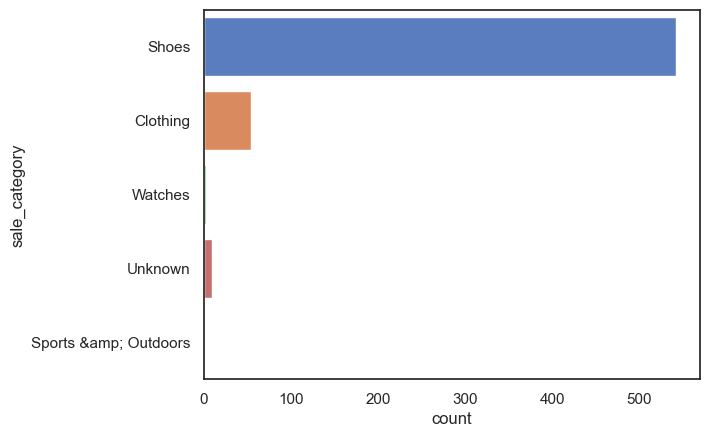

In [156]:
#plot the sales categories to see if there is a main product
sns.countplot(data=df_focus_prblm, y="sale_category")

In [157]:
#filter problem category to only focus on shoes
df_focus_prblm = df_focus_prblm[df_focus_prblm['sale_category'] == 'Shoes']

### Review the Top Products in the Topic

In [160]:
#slice of data table focused on uniqu products in the problem topic
df_prod_count = df_focus_prblm[['title', 'sentiment']]
df_prod_count = df_prod_count.groupby(['title']).agg(['mean', 'count']).reset_index()
df_prod_count.columns = ['_'.join(col) for col in df_prod_count.columns]
df_prod_count = df_prod_count.rename(columns={'title_': 'title', 'sentiment_count': 'count'})
df_prod_count = df_prod_count.sort_values(by=['count'], ascending=False).reset_index()
df_prod_count['sentiment_mean'] = [round(i,3) for i in df_prod_count['sentiment_mean']]
df_prod_count['title'] = [i[:50] for i in df_prod_count['title']]
print('There are', len(df_prod_count), 'unique products that are part of this category')

There are 347 unique products that are part of this category


In [159]:
#products with a count abive threshold for the topic
print('some of the top products:')
df_prod_count = df_prod_count[df_prod_count['count'] >= 5]
df_prod_count

some of the top products:


,index,title,sentiment_mean,count
0,171,Nike Men's Benassi Swoosh Slide Sandal,0.054,23
1,105,Nike Free 5.0 Womens Running Shoes,0.133,21
2,107,Nike Free 5.0+ Mens Running Shoes 579959-740,0.050,16
3,285,Nike Women's Comfort Thong Sandal,0.044,14
4,48,Nike 2014 Grillroom Golf Shoes Men's Anthracite/Wh,0.032,12
5,234,Nike Mens Cortez Basic Leather 06 Fashion Casual S,0.011,10
6,284,Nike Women's Comfort Slide,0.151,8
7,279,Nike Women's Air Pegasus+ 30 Running Shoe,0.157,7
8,245,Nike Shox NZ EU Mens Running Shoes,0.111,6
9,82,Nike Air Monarch IV Men's Cross Training Shoes,0.043,6


<Figure size 640x480 with 0 Axes>

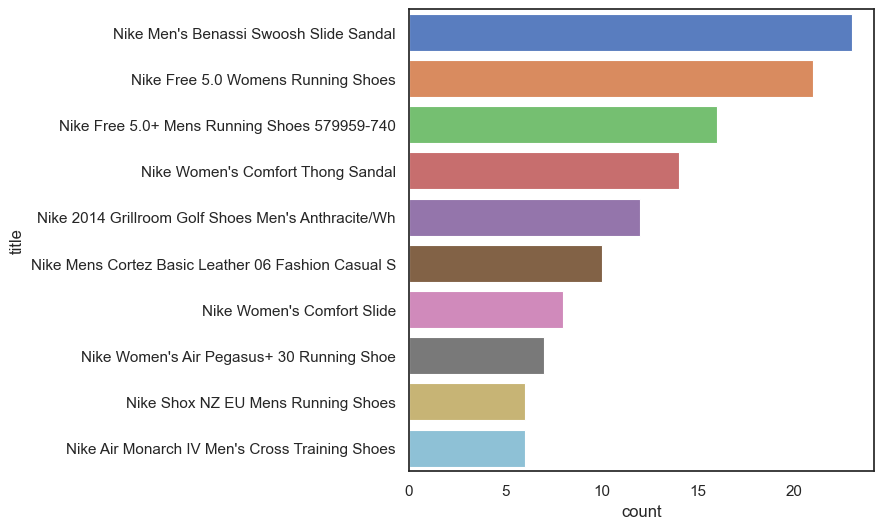

<Figure size 640x480 with 0 Axes>

In [161]:
#Most common products in the topic
f, ax = plt.subplots(1,1, figsize=(6, 6))
sns.set_context('paper', font_scale = 0.9)
ax = sns.barplot(data=df_prod_count.head(10), y='title', x = 'count', width=.8, ax=ax)
plt.figure()

### What Are People Saying

In [162]:
#best 10 reviews for topic
df_focus_prblm.sort_values(by=['sentiment'], ascending=False).reset_index().head(10)

,document,rank_1_topic,rank_1_prob,sentiment,asin,sale_category,title,text
0,8457,23_size_small_half_large,0.3444,0.812500,B004XUUXSC,Shoes,Nike Women' s Sweet Classic Leather,"These sneakers would have been awesome if they sent the size I ordered. I wish I could find them somewhere else, they are so cute!"
1,20160,23_size_small_half_large,0.3917,0.800000,B00E57PDMY,Shoes,Nike Women's Roshe Run,Great shoe but ran smal for size.
2,15201,23_size_small_half_large,0.3422,0.666667,B008E0BKF2,Shoes,Nike Solarsoft Thong Ii Print Womens 553486,"i'm a US size 9 and i realised that with nile products 8 fits excellent. so u may want to try a smaller size. i bought an 8, and it fits perfect."
3,20237,23_size_small_half_large,0.3180,0.600000,B00ED4AELY,Shoes,Nike Mens Lunar Pegasus 89 Running Shoes,"My husband has always loved the Nike running shoe, but wasn't to sure about ordering online. But they fit great."
4,16995,23_size_small_half_large,0.3482,0.600000,B00A83E2E4,Shoes,Nike Dunk High,"wine & cranberry. nice comborins a bit smalli got mine in a size 9 , but wouldve gotten 9"
5,5697,23_size_small_half_large,0.4756,0.541667,B003HD6KY2,Shoes,Nike Free 5.0 Womens Running Shoes,My feet feel really happy while I am walking in these shoes! I ordered a larger size after I read the reviews and I'm glad I did!
6,6860,23_size_small_half_large,0.3133,0.510189,B004D75AZG,Shoes,Nike Men's Air Max 1 Essential Running Shoe,"my 1st order from the states, since i live in germany. shoe's are nice as expected.super good feeling just NIKE.... super satisfied!!"
7,7606,23_size_small_half_large,0.4476,0.500000,B004OA24CO,Shoes,Air Jordan Hydro 2 (Kids),the information stated it was a mens 6 but ended up being a youth size not mens size ok otherwise
8,21546,23_size_small_half_large,0.3556,0.500000,B00K3YV7MS,Shoes,Nike Flyknit Lunar 1 For Women's Purple Color Size 12,size 12 more like size 10
9,5550,23_size_small_half_large,0.3833,0.500000,B003GEV9KW,Shoes,Jordan 6 Retro (Td) Toddlers,I ordered these shoes on Nov 14 and got them on Nov 18 fast delivery also it says pre- school but i ordered a size 3 and the size was correct when i recieved them great service.


In [163]:
#worst 10 reviews for topic
df_focus_prblm.sort_values(by=['sentiment'], ascending=True).reset_index().head(10)

,document,rank_1_topic,rank_1_prob,sentiment,asin,sale_category,title,text
0,15791,23_size_small_half_large,0.4278,-0.5000,B0098G7Q1S,Shoes,Nike Free 5.0+ Mens Running Shoes 579959-740,Runs small just like a lot of the reviewers said. All of my shoes are size 8. I probably should have bought a size 8.5. Oh well :(
1,10691,23_size_small_half_large,0.3482,-0.5000,B0059DD9GU,Shoes,Nike FREE XILLA TR Men's Training Shoe,I ordered the wrong size for a needy family for a Christmas Angel Tree when the spreadsheet with the boy's size was incorrect.
2,13429,23_size_small_half_large,0.4718,-0.3125,B00785XZBG,Shoes,Nike Womens Air Max 95 Sneakers,Disappointed! The shoe sizes run smaller than the listed size. Buyer beware...you have to pay to return the open item and you do not get reimbursed for the return amount
3,4372,23_size_small_half_large,0.4349,-0.2975,B002JB6VEC,Shoes,Nike Women's Comfort Thong Sandal,"Shoe is literally 2 sizes to small I wear a 9 so I ordered a 9, fits like a 7. Ended up buying a size 11 from a shoe store. When ordering go 2 sizes up. Also no return shipping label?! Very disappointing. Regardless with the correct size they are very comfy."
4,10530,23_size_small_half_large,0.3180,-0.2500,B0059D3QAE,Shoes,Nike Men's BLAZER LOW V White / White Fashion Sneakers SZ 9,"I usually wear size 9, but this size 9 is from another planet size - too small. I guess you have to go to a store to buy shoes because you can try them on."
5,15789,23_size_small_half_large,0.5167,-0.2500,B0098G7Q1S,Shoes,Nike Free 5.0+ Mens Running Shoes 579959-740,small not my size my size 11.5 and my order is 11.5 i dont no what the proplem i dont no what to do
6,10132,23_size_small_half_large,0.5074,-0.2500,B00595W522,Shoes,Womens Nike Shox Turbo+ 12 Running Shoe Black/Metallic Silver/Laser Pink/Black Size 9.5,My daughter likes these shoes but they are larger than other shoes. We went to the mall & tried on Nike's (they didn't have shox in her size) & we ordered the size she wore but these are a little big. Kinda disappointed!
7,10006,23_size_small_half_large,0.5133,-0.2500,B00594NTIW,Shoes,Nike In-Season TR Womens Size 10 Black Walking Shoes New/Display UK 7.5,"the shoes was another size and colour, too small, i dont know why send another shoes with the diferent sizebadddddddddddddddddddddddd"
8,6178,23_size_small_half_large,0.4133,-0.2500,B003V7ILZA,Shoes,Nike Men's Tiempo Genio Leather FG Soccer Cleat,"I wore this size before in another shoe, but this one was too small. nonetheless they were gracious and gave me a refund when i returned it."
9,18256,23_size_small_half_large,0.3556,-0.2500,B00B53I0GC,Shoes,Nike Mens Classic Cortez Vintage Anthracite Gold 511456-078 13,Always in nike i wear 13 US which is 47 eur but that one its comming small and tide from front


### Generate Topic Wordcloud

In [167]:
# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

topic_clouds = generate_wordclouds_for_topic_words(
    model_main.topic_word_, vocab_main,
    top_n=20, topic_labels=topic_labels_main,
    width=img_w, height=img_h
)

# show all generated word clouds
topic_clouds.keys()

dict_keys(['1_sandal_slide_clean_soft', '2_great_look_awesome_fit', '3_black_white_blue_red', '4_toe_narrow_lace_bit', '5_review_try_bad_problem', '6_find_store_amazon_hard', '7_pair_last_year_month', '8_shirt_short_fit_nice', '9_quality_product_good_excellent', '10_play_basketball_tennis_soccer', '11_run_mile_running_runner', '12_day_hour_foot_walk', '13_style_different_color_pair', '14_air_max_nike_model', '15_sneaker_boot_comfortable_stylish', '16_support_arch_heel_ankle', '17_bag_gym_use_hold', '18_gift_christmas_husband_say', '19_fast_delivery_arrive_condition', '20_sock_dry_tight_stay', '21_compliment_lot_stylish_get', '22_true_size_woman_man', '23_size_small_half_large', '24_watch_band_wrist_feature', '25_light_weight_training_workout', '26_worth_money_pay_spend', '27_look_leather_star_picture', '28_son_old_school_kid', '29_color_love_bright_super', '30_return_send_seller_item'])

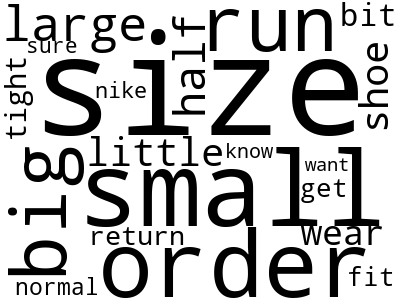

In [168]:
#display wordcloud for a topic
topic_clouds['23_size_small_half_large']

## Results

**Model**

The final Topic Model produced 30 topics that clusted the Nike brand reviews into groups. After completing a sentiment analysis, the following clusters were the top 5 positive and negative clusters.

|Rank| |Positive| |Negative|
|----|--|--------|--|--------|
| 1  | |21_compliment_lot_stylish_get| |30_return_send_seller_item|
| 2  | |25_light_weight_training_workout| |23_size_small_half_large|
| 3  | |19_fast_delivery_arrive_condition| |4_toe_narrow_lace_bit|
| 4  | |29_color_love_bright_super| |5_review_try_bad_problem |
| 5  | |2_great_look_awesome_fit| |7_pair_last_year_month|


After completing a deep dive into the topic of 23_size_small_half_large. Overall customers were mostly talking about he fit of shoes in this category and that they either (1) new to size up a half size larger or (2) received shoes and wished they sized up a half size larger. We were able to identify some additional insights for Nike that groups into 3 key categories:
- Experienced Customers
- Customer Experience and Support
- Product Opportunity

**Experienced Customers**

Generally speaking, customers who knew the Nike brand, knew to size-up when buying shoes. While they talked about this topic, they tended to order the correct size, have a more positive sentiment in their review, and provide a positive rating (4 or 5). What can be taken away from this is that the Nike brand can be challenging for new customers, especially when shopping online. Perhaps marketing spending for new customers should be focused more on getting that new customer into a store to get their initial brand experience.

**Customer Experience and Support**

Customers who order their "correct" shoe size and get shoes that don't fit are frustrated. They generally provide a negative rating (1 or 2) and have a low or negative sentiment. This is not a good customer experience, but based on the experienced customer reviews, this appears to be preventable. Nike should invest in text, images, apps, etc. that can better support customers in selecting the best size of shoe. If they can get a customer to order the correct size, they are more likely to have a happy customer. As seen by both posititve and negative reviews grouped together, the topic isn't inherently negative. Customers are ok with the fact that product runs small, they simply are frustrated and angry when their knowledge and expectations don't match what they receive. A solution to support customers can go a long way here.

**Product Opportunity**

By focusing on the products (specific shoes) within this topic, we can identify the top 5 shoes that seem to have fit (product) sizing issues. By using the below list, Nike can focus on specific products and make changes in their design to better address the sizing of the product in future iterations.

In [169]:
print('top 5 products to address:')
df_prod_count.head(5)

top 5 products to address:


,index,title,sentiment_mean,count
0,171,Nike Men's Benassi Swoosh Slide Sandal,0.054,23
1,105,Nike Free 5.0 Womens Running Shoes,0.133,21
2,107,Nike Free 5.0+ Mens Running Shoes 579959-740,0.050,16
3,285,Nike Women's Comfort Thong Sandal,0.044,14
4,48,Nike 2014 Grillroom Golf Shoes Men's Anthracite/Wh,0.032,12
